In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
from scipy.optimize import curve_fit
import sys
import seaborn as sns
import math
output_path = './RDC_analyses/'


# find if existing numpy files exist (i.e., this one has been run and saved)
def find_npy_filenames(path_to_dir, suffix=".npy"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def find_fasta_filenames(path_to_dir, suffix=".fasta"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def find_dat_filenames(path_to_dir, suffix=".dat"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# function to parse calculated RDC data
def read_calc_RDCs(filename):
    residues = []
    data = []
    with open(filename,'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            residues.append(int(line.split(',')[0]))

        for line in lines[1:]:
            dat = np.array(line.split(',')[1:]).astype(float)
            data.append(dat)

    data = np.array(data).T * -1 # account for negative gyromagnetic ratio of 15N

    return residues, data

def scale_rdcs_to_minimize_q(calc, exp, weights, prior='True', scale_matching = 'True'):
    calc = np.array(calc)
    exp = np.array(exp)

    if prior=='True':
        mask_nan = ~np.isnan(weights) # to remove unphysical conformations from averagin
        calc = np.average(calc[mask_nan, :], axis=0)
    else:
        weights = np.nan_to_num(weights,nan=0)
        weights = weights / np.sum(weights)
        calc = np.average(calc, weights=weights, axis=0)

    # if scale_matching - extract datapoints satisfying this
    if scale_matching=='True':
        try:
            prod = calc*exp
            keepidxs = np.where(prod>0)[0]
            #print('keeping {} / {} datapoints for scaling...'.format(keepidxs.shape[0], calc.shape[0]))
            calcfilt = calc[keepidxs]
            expfilt = exp[keepidxs]
            # Compute unconstrained scaling factor
            s = np.sum(calcfilt * expfilt) / np.sum(calcfilt ** 2)
        except:
            print('Warning: no matching RDCs found for scaling, returning nothing...')
            return

    else:
        # Compute unconstrained scaling factor
        s = np.sum(calc * exp) / np.sum(calc ** 2)

    # Constrain s to be ≥ 0 (should be satisfied already if scale_matching)
    s = max(s, 0)

    scaled = s * calc
    q = np.sqrt(np.mean((scaled - exp)**2)) / np.sqrt(np.mean(exp**2))
    q_nonscaled = np.sqrt(np.mean((calc - exp)**2)) / np.sqrt(np.mean(exp**2))

    return scaled, s, q, q_nonscaled


In [ ]:
# analyse all proteins for which there are RDC data

exp_path = '../EXP_DATA/'

models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 


# chemical shift predictor used for CS reweighting
CS_predictor = 'UCBshift'

# === CONFIG ===
### MAKE SURE TO REPLACE THE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# proteins with RDC data
rdc_proteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/RDC_HN.dat"):
        rdc_proteins.append(protein)

rdcdict = {}

for model in models:

    rdcdict[model] = {}

    for protein in rdc_proteins:

        rdcdict[model][protein] = {}

        # get protein sequence length from fasta
        with open(fasta_dir+f"{protein}.fasta",'r') as f:
            seq = f.readlines()[1].strip()
            prot_length = len(seq)

        # check calculated test RDCs
        if not os.path.exists(f'../protonated_predictions/{model}/{protein}/CSrew_{CS_predictor}.npy'):
            continue
        residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{protein}/RDC.csv')
        csrew = np.load(f'../protonated_predictions/{model}/{protein}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
        if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
            continue
        weights = csrew['weights']
        weights_nan = weights
        weights = np.nan_to_num(weights, nan=0)

        # experimental data
        expres = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat').astype(int)[:,0]
        exprdc = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat')[:,1]

        # remove nan rows
        exp_mask_nan = ~np.isnan(exprdc)
        expres = expres[exp_mask_nan]
        exprdc = exprdc[exp_mask_nan]

        # remove first and last residue from experiment
        if expres[0]==1:
            expres=expres[1:]
            exprdc=exprdc[1:]
        elif expres[-1]==prot_length:
            expres=expres[:-1]
            exprdc=exprdc[:-1]

        # sim indices for which there are experiments
        idxs = []
        for ele in expres:
            idx = list(residues).index(ele)
            idxs.append(idx)
        idxs=np.array(idxs).astype(int)
        residues= np.array(residues)[idxs]
        data = np.array(data)[:,idxs]

        # assess fit of calculated RDCs with respect to exp. data
        scaled_, s_, q_, q_nonscaled_ = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
        scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior= 'False', scale_matching = 'True')
        #scaled_, s_, q_, q_nonscaled_ = scale_rdcs_mean_abs_magnitude(data, exprdc, weights_nan, prior='True')
        #scaled, s, q, q_nonscaled = scale_rdcs_mean_abs_magnitude(data, exprdc, weights, prior= 'False')

        rdcdict[model][protein]['Prior Q'] = q_
        rdcdict[model][protein]['Post. Q'] = q
        rdcdict[model][protein]['Residues'] = residues
        rdcdict[model][protein]['Exp'] = exprdc
        rdcdict[model][protein]['Prior'] = scaled_
        rdcdict[model][protein]['Post.'] = scaled


print("finished")




/tmp/ipykernel_2984478/2597944364.py:57: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat').astype(int)[:,0]


finished


In [3]:
# summary barplots of q-factors

qfac_mu = []
qfac_sd = []
qfac_median = []
qfac_prior_mu = []
qfac_prior_sd = []
qfac_prior_median = []
qfac_min = []
qfac_prior_min = []

allvalues = {}
allvalues_prior = {}

for model in models:

    values = []
    values_prior = []
    tmpprot = []

    for protein in list(rdcdict[model].keys()):

        if len(list(rdcdict[model][protein]))==0:
            continue

        tmpprot.append(protein)
        values.append(rdcdict[model][protein]['Post. Q'])
        values_prior.append(rdcdict[model][protein]['Prior Q'])

    allvalues[model] = values
    allvalues_prior[model] = values_prior
    qfac_mu.append(np.mean(values))
    qfac_prior_mu.append(np.mean(values_prior))
    qfac_sd.append(np.std(values))
    qfac_prior_sd.append(np.std(values_prior))
    qfac_median.append(np.median(values))
    qfac_prior_median.append(np.median(values_prior))
    qfac_min.append(np.min(values))
    qfac_prior_min.append(np.min(values_prior))
    print(model, "Min. Q-factor:", tmpprot[np.where(values==np.min(values))[0][0]])
    print(model, "Min. Q-factor no rew.:", tmpprot[np.where(values_prior==np.min(values_prior))[0][0]])
    print(model, "Max. Q-factor:", tmpprot[np.where(values==np.max(values))[0][0]])
    print(model, "Max. Q-factor no rew.:", tmpprot[np.where(values_prior==np.max(values_prior))[0][0]])

df = pd.DataFrame()

df['Model'] = models
df['Q-factor mean'] = qfac_mu
df['Q-factor median'] = qfac_median
df['Q-factor sd'] = qfac_sd
df['Q-factor no rew. mean'] = qfac_prior_mu
df['Q-factor no rew. median'] = qfac_prior_median
df['Q-factor no rew. sd'] = qfac_prior_sd
df['min. Q-factor'] = qfac_min
df['min. Q-factor no rew.'] = qfac_prior_min
print(np.min(df['Q-factor mean']))
print(np.min(df['Q-factor no rew. mean']))
df


alphafold Min. Q-factor: Ab40
alphafold Min. Q-factor no rew.: Ab40
alphafold Max. Q-factor: ACTR
alphafold Max. Q-factor no rew.: ACTR
bioemu Min. Q-factor: Sic1
bioemu Min. Q-factor no rew.: Sic1
bioemu Max. Q-factor: aSyn
bioemu Max. Q-factor no rew.: aSyn
boltz2 Min. Q-factor: Ab40
boltz2 Min. Q-factor no rew.: Sic1
boltz2 Max. Q-factor: aSyn
boltz2 Max. Q-factor no rew.: aSyn
esmflow Min. Q-factor: Sic1
esmflow Min. Q-factor no rew.: Sic1
esmflow Max. Q-factor: aSyn
esmflow Max. Q-factor no rew.: aSyn
esmfold Min. Q-factor: FLN5A3A3
esmfold Min. Q-factor no rew.: FLN5A3A3
esmfold Max. Q-factor: RCFTR
esmfold Max. Q-factor no rew.: RCFTR
idpgan Min. Q-factor: aSyn
idpgan Min. Q-factor no rew.: aSyn
idpgan Max. Q-factor: PaaA2
idpgan Max. Q-factor no rew.: PaaA2
idp-o Min. Q-factor: p53NTD
idp-o Min. Q-factor no rew.: Sic1
idp-o Max. Q-factor: drkN
idp-o Max. Q-factor no rew.: ACTR
peptron_stable_pdb_idrome_20250812_256000 Min. Q-factor: Sic1
peptron_stable_pdb_idrome_20250812_25600

Model  Q-factor mean  Q-factor median  \
0                                  alphafold       1.054912         1.027308   
1                                     bioemu       0.818551         0.773072   
2                                     boltz2       0.974543         0.966542   
3                                    esmflow       0.965603         0.819827   
4                                    esmfold       1.178407         1.139307   
5                                     idpgan       0.815895         0.787198   
6                                      idp-o       0.683161         0.658710   
7  peptron_stable_pdb_idrome_20250812_256000       0.829678         0.762834   
8         peptron_stable_pdb_20250809_236800       0.892392         0.836938   

   Q-factor sd  Q-factor no rew. mean  Q-factor no rew. median  \
0     0.213420               1.054912                 1.027308   
1     0.259137               0.908048                 0.825475   
2     0.360942               1.180968                 1.140272   
3     0.422101               1.001260                 0.820815   
4     0.215695               1.178407                 1.139307   
5     0.224740               0.815754                 0.787199   
6     0.174272               0.806114                 0.757214   
7     0.316314               0.954111                 0.890064   
8     0.314685               0.951374                 0.858672   

   Q-factor no rew. sd  min. Q-factor  min. Q-factor no rew.  
0             0.213420       0.665893               0.665893  
1             0.314341       0.428953               0.425629  
2             0.458563       0.566054               0.690033  
3             0.446804       0.444997               0.497963  
4             0.215695       0.902384               0.902384  
5             0.222915       0.482920               0.482921  
6             0.223694       0.461492               0.477259  
7             0.408110       0.401044               0.453818  
8             0.369613       0.439683               0.474160

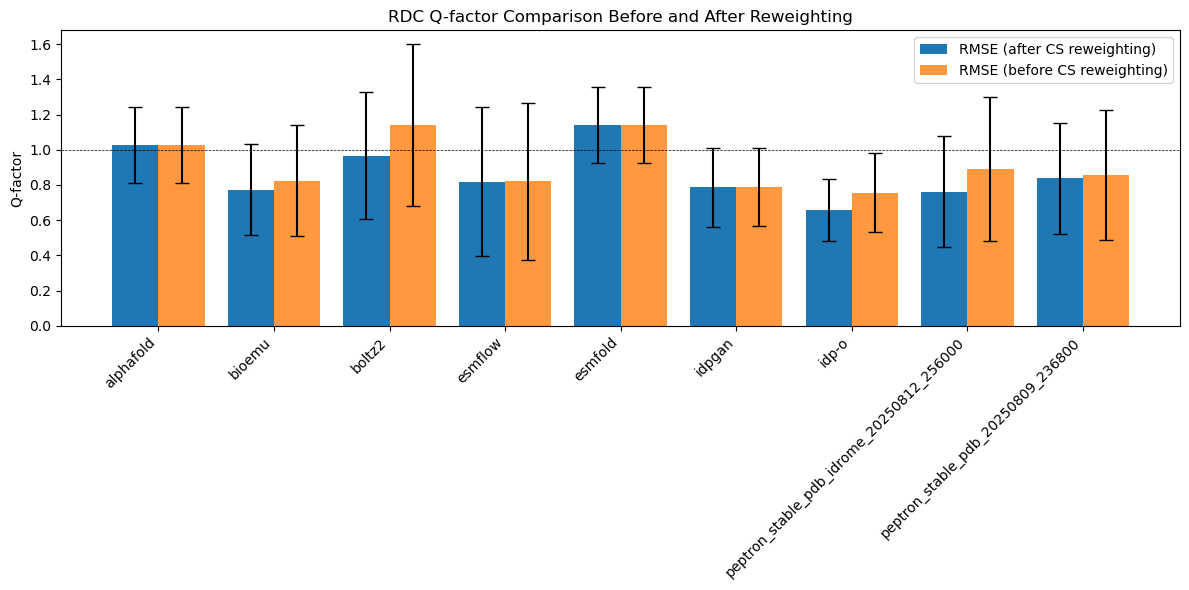

In [4]:
# bar plot of Q-factors before/after reweighting
# Create bar positions
x = np.arange(len(df["Model"]))  # the label locations
width = 0.4  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bars
rects1 = ax.bar(x - width/2, df["Q-factor median"], width, yerr=df["Q-factor sd"], capsize=5, label="RMSE (after CS reweighting)")
rects2 = ax.bar(x + width/2, df["Q-factor no rew. median"], width, yerr=df["Q-factor no rew. sd"], capsize=5, label="RMSE (before CS reweighting)", alpha=0.8)

# Labels and formatting
ax.set_ylabel("Q-factor")
ax.set_title("RDC Q-factor Comparison Before and After Reweighting")
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], rotation=45, ha="right")
ax.legend()
ax.axhline(1,color = 'black',linestyle= 'dashed', linewidth=0.5)

plt.tight_layout()
#plt.savefig(output_path+'RDC_Qfactors_models.png', dpi=300)

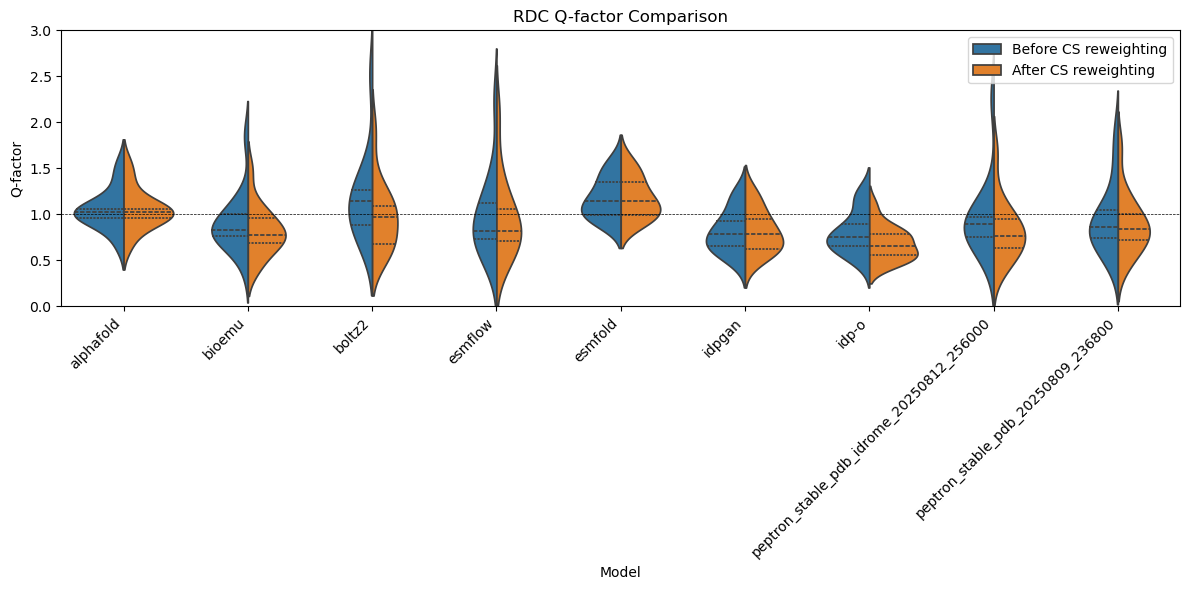

In [5]:
# violin plot

df_list = []

# Before reweighting
for model, vals in allvalues_prior.items():
    df_list.append(pd.DataFrame({
        "Model": model,
        "Condition": "Before CS reweighting",
        "Q-factor": vals
    }))

# After reweighting
for model, vals in allvalues.items():
    df_list.append(pd.DataFrame({
        "Model": model,
        "Condition": "After CS reweighting",
        "Q-factor": vals
    }))

# Combine into long DataFrame
df_long = pd.concat(df_list, ignore_index=True)

# Plot violin plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(
    data=df_long,
    x="Model",
    y="Q-factor",
    hue="Condition",
    split=True,        # both distributions in one violin per model
    inner="quartile",  # show median and quartiles
    ax=ax
)

# Formatting
ax.set_ylabel("Q-factor")
ax.set_title(f"RDC Q-factor Comparison")
ax.axhline(1, color="black", linestyle="dashed", linewidth=0.5)
ax.legend(title="")
plt.ylim(0.,3)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig(output_path+"RDC_Qfactors_violin.png", dpi=300)

In [ ]:
# cross-correlation analysis
# RDC Q-factor as a function of theta or ESS
# the final posterior is chosen as the ensemble with best RDC agreement satisfying ESS >= 100 - else the prior is taken (i.e., no reweighting due to small ensemble size)

exp_path = '../EXP_DATA/'

models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 


# chemical shift predictor used for CS reweighting
CS_predictor = 'UCBshift'

# === CONFIG ===
### MAKE SURE TO REPLACE THE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# proteins with RDC data
rdc_proteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/RDC_HN.dat"):
        rdc_proteins.append(protein)

corrdict = {}

for model in models:

    corrdict[model] = {}

    for protein in rdc_proteins:

        # get protein sequence length from fasta
        with open(fasta_dir+f"{protein}.fasta",'r') as f:
            seq = f.readlines()[1].strip()
            prot_length = len(seq)

        # check calculated test RDCs
        if not os.path.exists(f'../protonated_predictions/{model}/{protein}/CSrew_{CS_predictor}.npy'):
            continue
        residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{protein}/RDC.csv')
        csrew = np.load(f'../protonated_predictions/{model}/{protein}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
        if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
            continue

        corrdict[model][protein] = {}
        weights_nan = csrew['weights']
        wopt_array = csrew['all_weights']
        ESS_array = csrew['all_ess']
        CS_RMSE_array = csrew['all_post_rmse']
        CS_RMSE_prior = csrew['prior_rmse']

        # experimental data
        expres = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat').astype(int)[:,0]
        exprdc = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat')[:,1]

        # remove nan rows
        exp_mask_nan = ~np.isnan(exprdc)
        expres = expres[exp_mask_nan]
        exprdc = exprdc[exp_mask_nan]

        # remove first and last residue from experiment
        if expres[0]==1:
            expres=expres[1:]
            exprdc=exprdc[1:]
        elif expres[-1]==prot_length:
            expres=expres[:-1]
            exprdc=exprdc[:-1]

        # sim indices for which there are experiments
        idxs = []
        for ele in expres:
            idx = list(residues).index(ele)
            idxs.append(idx)
        idxs=np.array(idxs).astype(int)
        residues= np.array(residues)[idxs]
        data = np.array(data)[:,idxs]

        # assess fit of calculated RDCs with respect to exp. data
        scaled_, s_, q_, q_nonscaled_ = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')

        # all posterior weights
        Qfactor_array = []
        for w in wopt_array:
            scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, w, prior= 'False', scale_matching='True')
            Qfactor_array.append(q)

        corrdict[model][protein]['Prior Q'] = q_
        corrdict[model][protein]['Prior CS RMSE'] = CS_RMSE_prior
        corrdict[model][protein]['Post. Q'] = Qfactor_array
        corrdict[model][protein]['CS RMSE'] = CS_RMSE_array
        corrdict[model][protein]['ESS'] = ESS_array
        corrdict[model][protein]['Residues'] = residues

np.save(output_path+'RDC_CSrew_corr_analysis_dict.npy',corrdict)
print("finished")




/tmp/ipykernel_2984478/710970760.py:61: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat').astype(int)[:,0]
/tmp/ipykernel_2984478/3825885993.py:53: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)
/tmp/ipykernel_2984478/3825885993.py:65: RuntimeWarning: invalid value encountered in scalar divide
  s = np.sum(calcfilt * expfilt) / np.sum(calcfilt ** 2)


finished


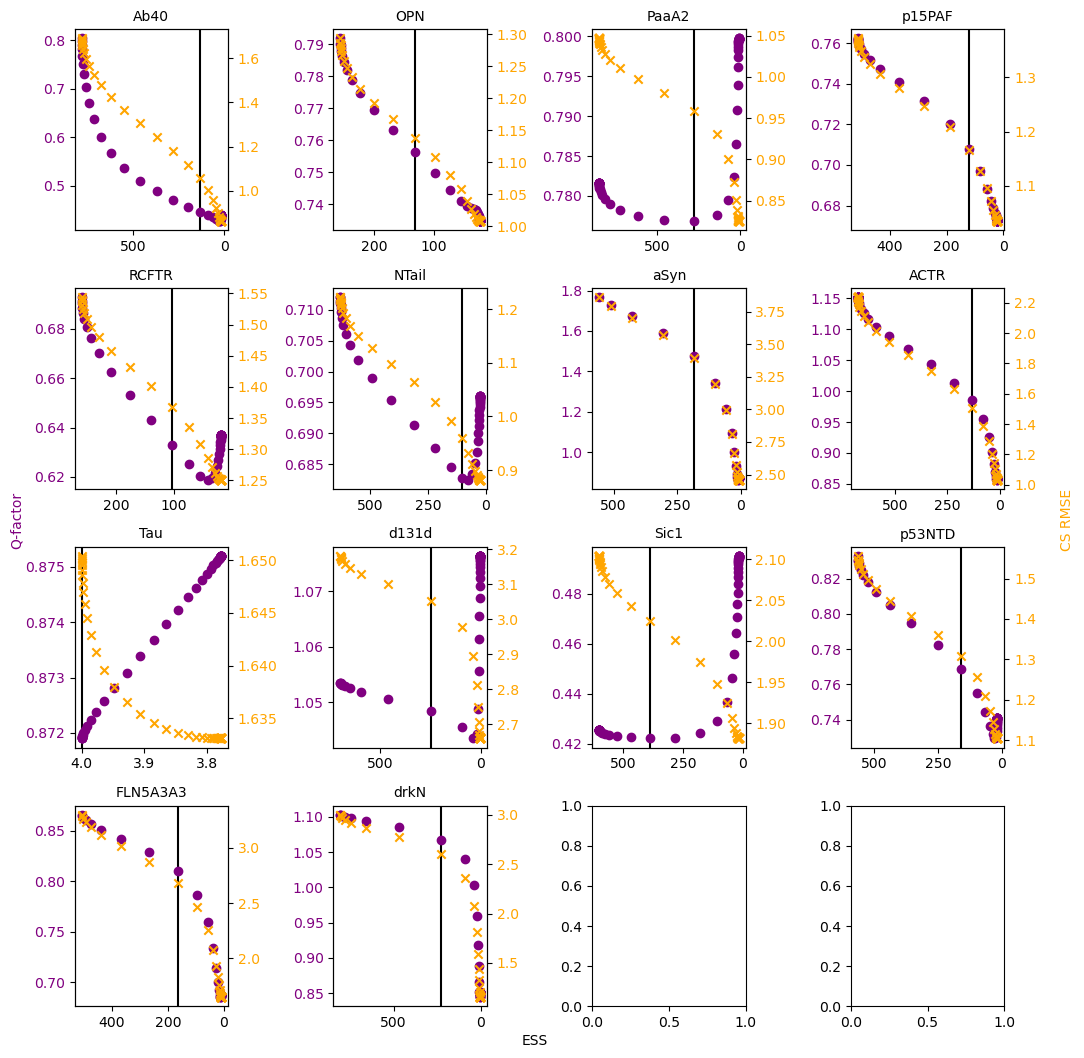

In [38]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'bioemu'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



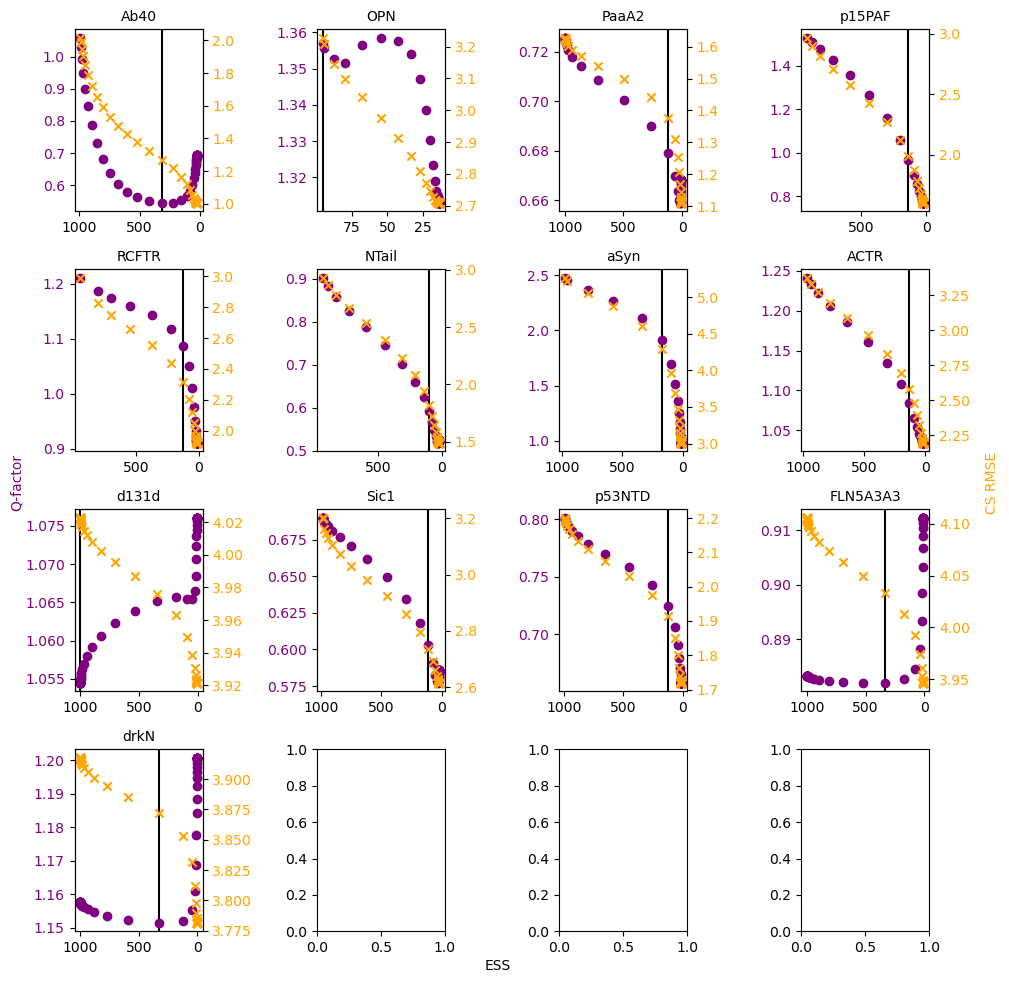

In [39]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'boltz2'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



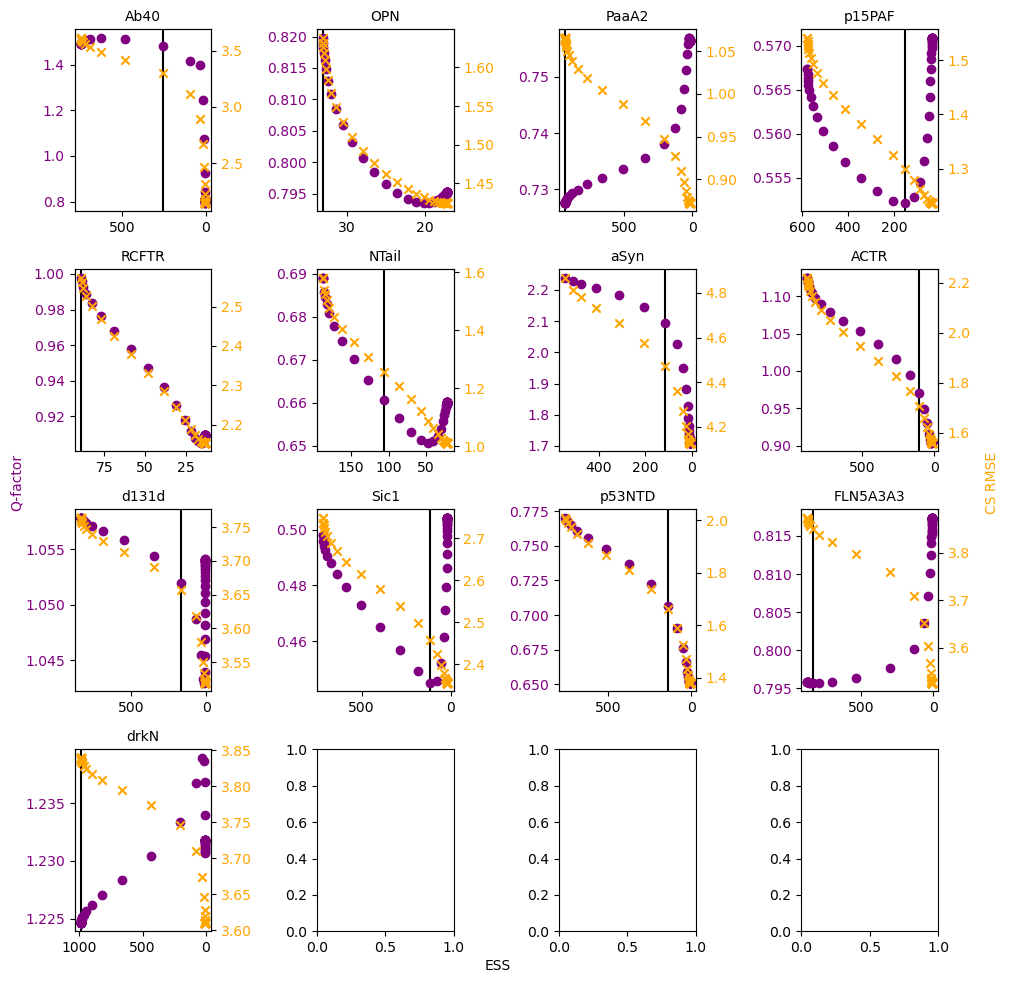

In [40]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'esmflow'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



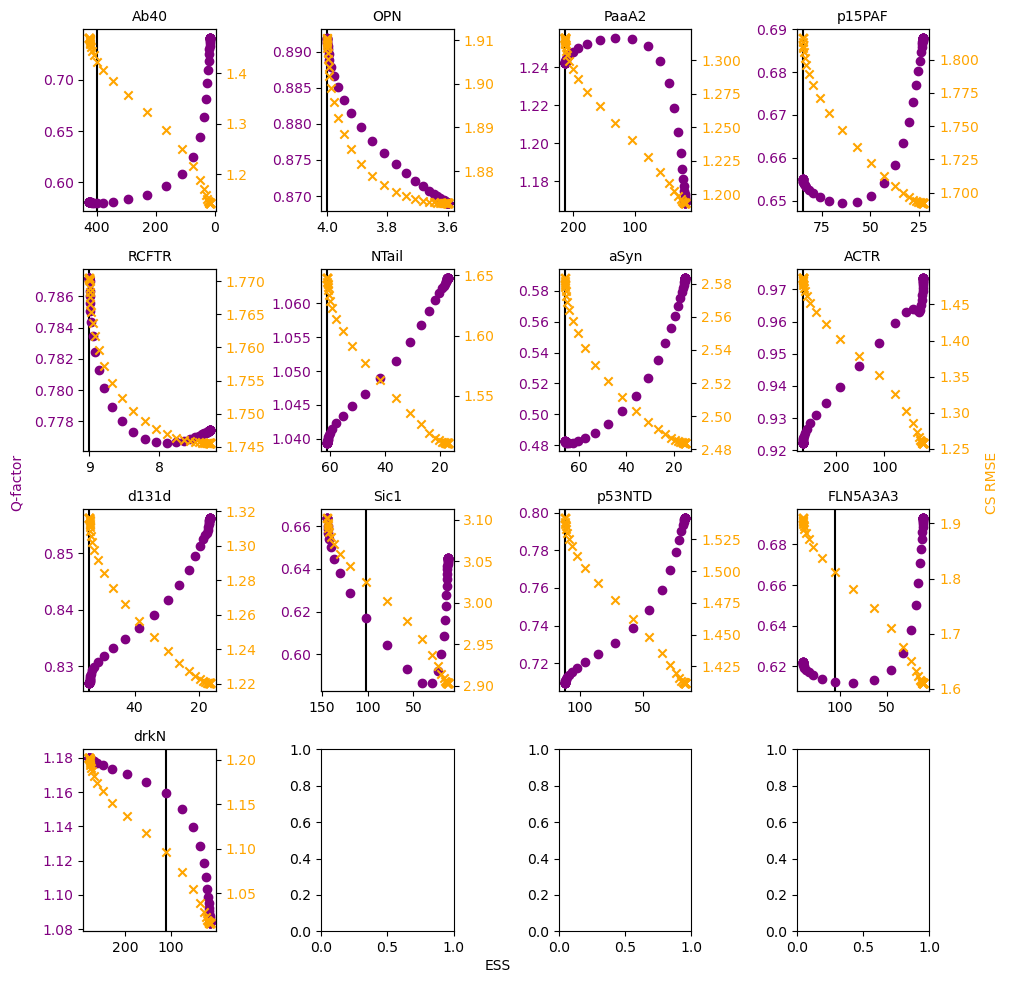

In [41]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'idpgan'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



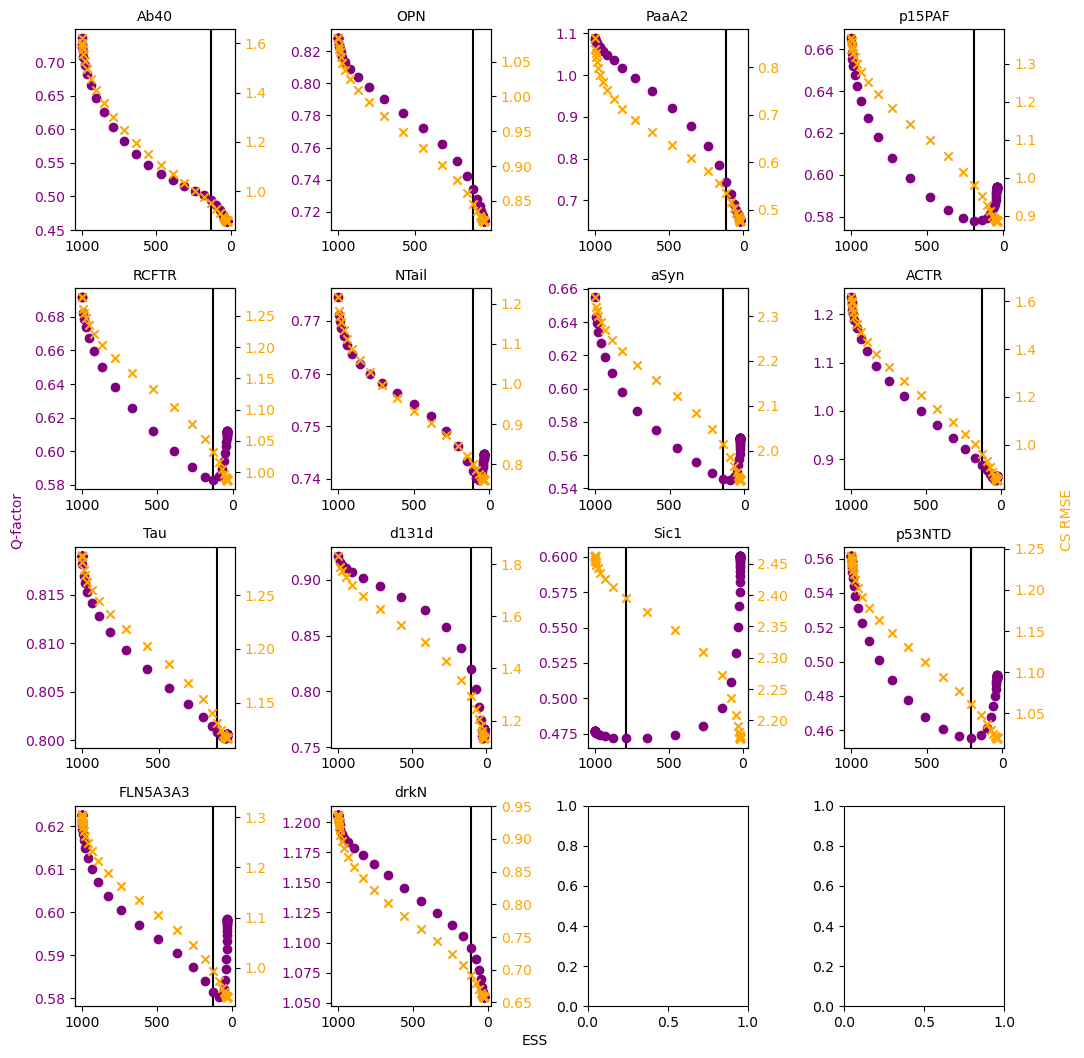

In [42]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'idp-o'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



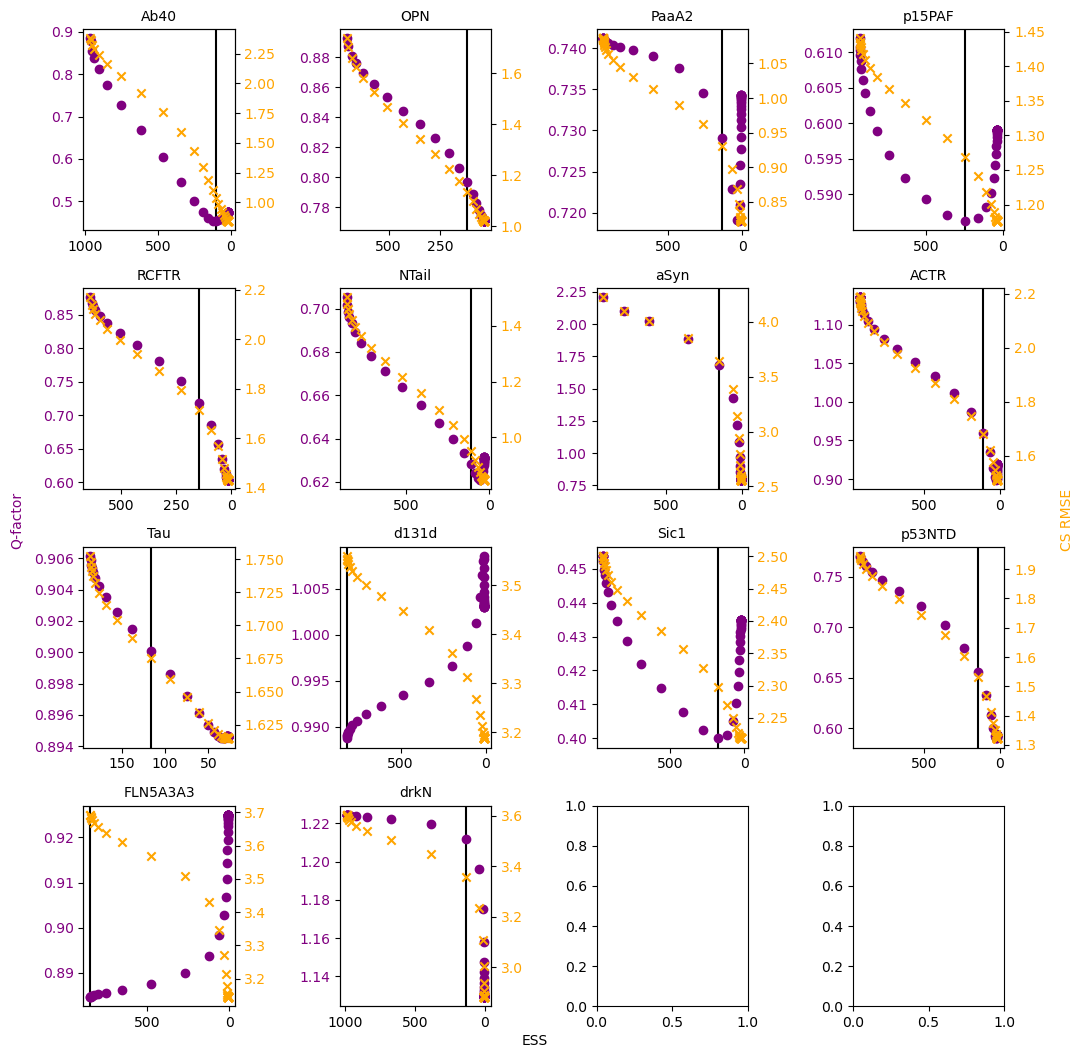

In [43]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'peptron_stable_pdb_idrome_20250812_256000'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



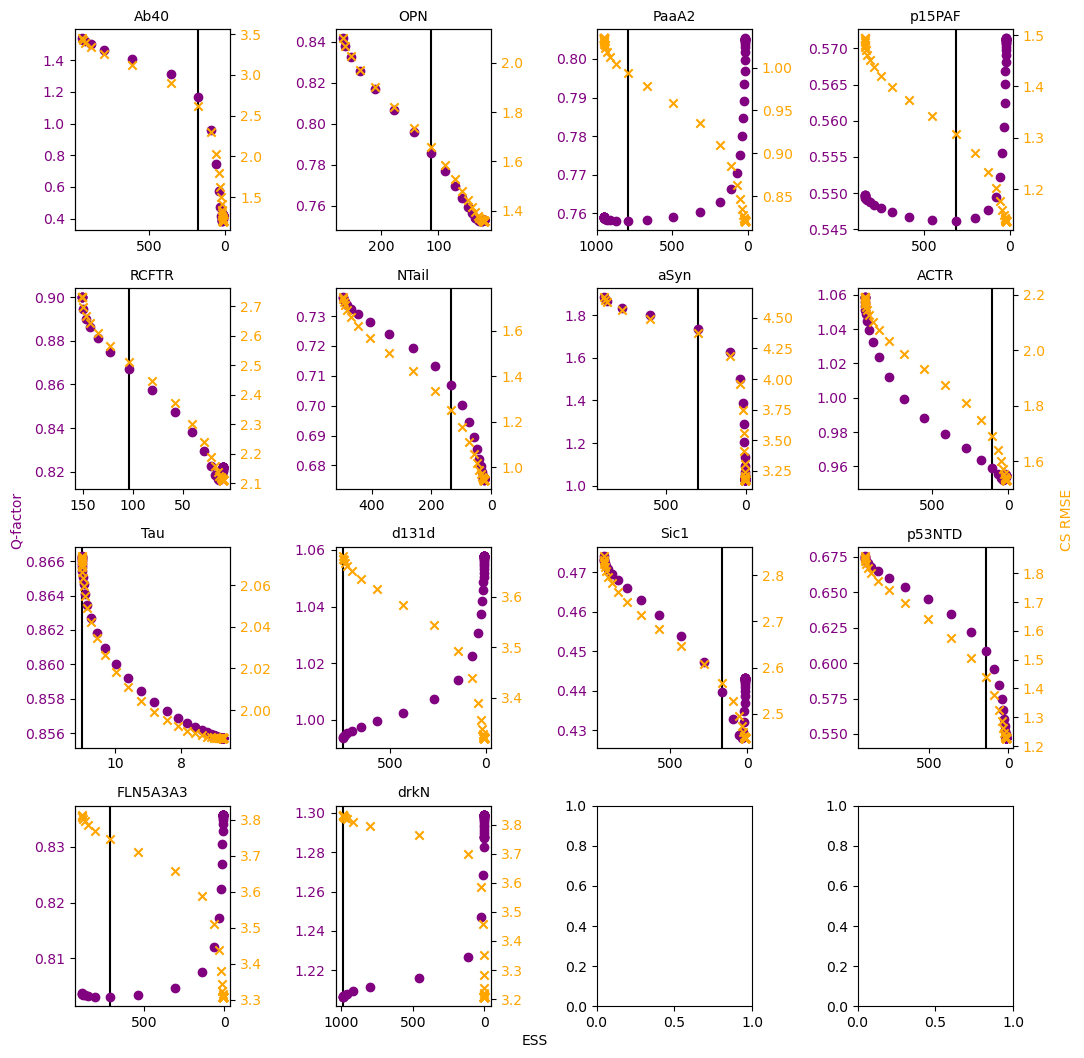

In [44]:
# plot results (ESS on x-axis, left y-axis Q-factor, right y-axis CS RMSE)

model = 'peptron_stable_pdb_20250809_236800'
ESS_threshold=100
RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*0.75,len(RDCproteins)*0.75))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # left y-axis (RDC Q-factor)
    ax.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['Post. Q'], label='Q-factor', color='purple')
    ax.tick_params(axis='y', labelcolor="purple")
    # Flip the x-axis
    ax.invert_xaxis()

    # right y-axis (ESS)
    ax2 = ax.twinx()
    ax2.scatter(corrdict[model][prot]['ESS'], corrdict[model][prot]['CS RMSE'], label='CS RMSE', color='orange', marker='x')
    ax2.tick_params(axis='y', labelcolor="orange")

    # highlight optimal posterior (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    
    ax.axvline(corrdict[model][prot]['ESS'][min_idx],color='black', zorder=-10)


# Set one master x and y label
fig.text(0.5, 0.0, 'ESS', ha='center', fontsize=10)  # shared x-label
fig.text(0.0, 0.5, 'Q-factor', va='center', rotation='vertical', fontsize=10, color='purple')  # left y-label
fig.text(1.0, 0.5, 'CS RMSE', va='center', rotation='vertical', fontsize=10, color='orange')    # right y-label


plt.tight_layout()
plt.savefig(output_path+f'RDC_CSrew_correlation_{CS_predictor}_{model}.png', dpi=200)



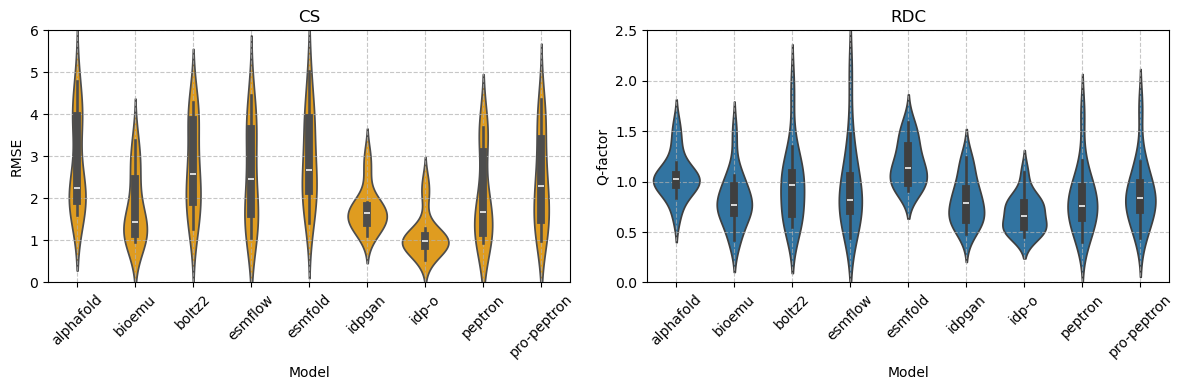

In [7]:
# final bar plots
# using the cross-correlation curves - we find the optimal reweighting theta (where RDC agreement is best to avoid overfitting)
# then we get the statistics for these posterior ensembles

models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 
ESS_threshold=100

statsdict = {}

for model in models:

    proteins = list(corrdict[model].keys())
    qfactors = []
    cs_rmse = []
    for prot in proteins:
        # find optimal posterior
        # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
            min_idx = min_idx
        if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
        if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
            min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
            
        qfactors.append(corrdict[model][prot]['Post. Q'][min_idx])
        cs_rmse.append(corrdict[model][prot]['CS RMSE'][min_idx])
    
    statsdict[model] = {}
    statsdict[model]['Q-factor'] = qfactors
    statsdict[model]['CS RMSE'] = cs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Violin plot for CS RMSE
sns.violinplot(data=df[df["Metric"]=="CS RMSE"], 
               x="Model", y="Value", ax=axes[0], inner="box", color="orange")
axes[0].set_title("CS")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, which='major', linestyle='--', alpha=0.7)
axes[0].set_ylim(0,6)

# Violin plot for Q-factor
sns.violinplot(data=df[df["Metric"]=="Q-factor"], 
               x="Model", y="Value", ax=axes[1], inner="box")
axes[1].set_title("RDC")
axes[1].set_ylabel('Q-factor')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, which='major', linestyle='--', alpha=0.7)
axes[1].set_ylim(0,2.5)

plt.tight_layout()
#plt.savefig(output_path+f"final_CS_RDC_stats_crosscorr.png", dpi=300)


/tmp/ipykernel_2984478/3124395485.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
/tmp/ipykernel_2984478/3124395485.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)


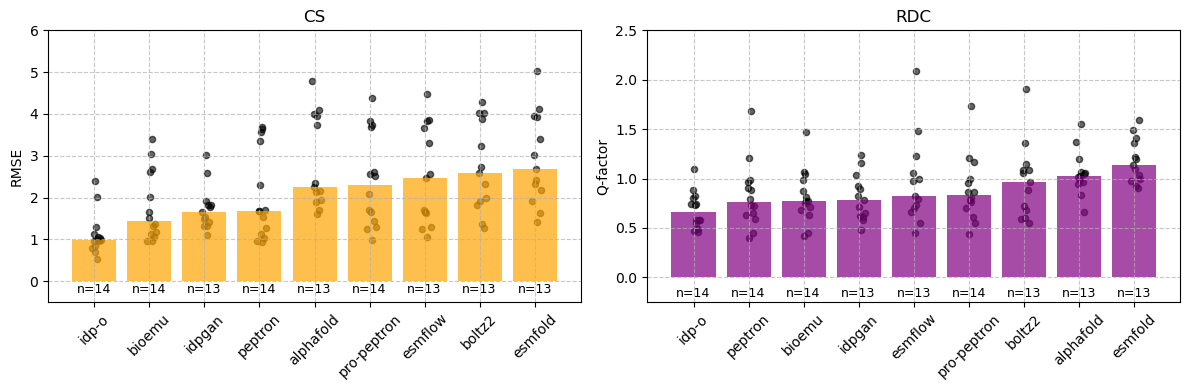

In [8]:
# final bar plots
# using the cross-correlation curves - we find the optimal reweighting theta (where RDC agreement is best to avoid overfitting)
# then we get the statistics for these posterior ensembles

models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 
ESS_threshold=100

statsdict = {}

for model in models:

    proteins = list(corrdict[model].keys())
    qfactors = []
    cs_rmse = []
    for prot in proteins:
        # find optimal posterior
        # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
            min_idx = min_idx
        if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
        if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
            min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
            
        qfactors.append(corrdict[model][prot]['Post. Q'][min_idx])
        cs_rmse.append(corrdict[model][prot]['CS RMSE'][min_idx])
    
    statsdict[model] = {}
    statsdict[model]['Q-factor'] = qfactors
    statsdict[model]['CS RMSE'] = cs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron",
     "peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, metric in enumerate(["CS RMSE", "Q-factor"]):
    df_metric = df[df["Metric"]==metric]
    
    # Compute medians & counts, sort ascending by median
    summary = df_metric.groupby("Model")["Value"].agg(["median", "count"]).reset_index()
    summary = summary.sort_values("median", ascending=True).reset_index(drop=True)
    
    # Ensure df follows same model order
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
    
    ax = axes[i]
    
    # Bar plot for medians
    ax.bar(summary["Model"], summary["median"], color="orange" if metric=="CS RMSE" else "purple", alpha=0.7)
    
    # Scatter plot for all points with jitter
    for j, model in enumerate(summary["Model"]):
        vals = df_metric[df_metric["Model"]==model]["Value"].values
        np.random.seed(0)
        x_jittered = np.random.normal(loc=j, scale=0.05, size=len(vals))
        ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)
    
    # Annotate counts below x-ticks
    for j, row in summary.iterrows():
        ax.text(j, -0.05 if metric=="CS RMSE" else -0.1, f"n={row['count']}", ha="center", va="top", fontsize=9)
    
    # Set labels and title
    ax.set_title("CS" if metric=="CS RMSE" else "RDC")
    ax.set_ylabel("RMSE" if metric=="CS RMSE" else "Q-factor")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Set y-limits
    if metric=="CS RMSE":
        ax.set_ylim(-0.5, 6)
    else:
        ax.set_ylim(-0.25, 2.5)

plt.tight_layout()
#plt.savefig(output_path + "final_CS_RDC_stats_crosscorr.png", dpi=300)


Number of common proteins (after reweighting): 12


/tmp/ipykernel_2984478/2354518837.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
/tmp/ipykernel_2984478/2354518837.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)


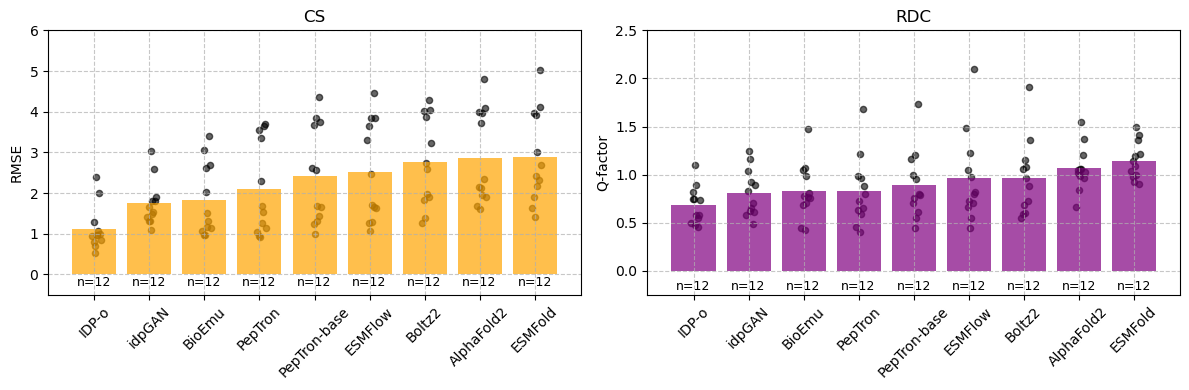

In [15]:
models = [ 
    'alphafold', 'bioemu', 'boltz2', 'esmflow', 'esmfold',
    'idpgan', 'idp-o',
    'peptron_stable_pdb_idrome_20250812_256000',
    'peptron_stable_pdb_20250809_236800'
]
ESS_threshold = 100

# restrict to common proteins
all_protein_sets = [set(corrdict[m].keys()) for m in models]
common_proteins = set.intersection(*all_protein_sets)
print(f"Number of common proteins (after reweighting): {len(common_proteins)}")

statsdict = {}

for model in models:
    qfactors = []
    cs_rmse = []
    for prot in common_proteins:  
        # find optimal posterior
        # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
        min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        
        if corrdict[model][prot]['ESS'][min_idx] >= ESS_threshold:  
            min_idx = min_idx
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold and np.nanmax(corrdict[model][prot]['ESS']) > ESS_threshold:  
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(valid))[0][0]
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold:
            min_idx = np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0]  # first index not nan
        
        qfactors.append(corrdict[model][prot]['Post. Q'][min_idx])
        cs_rmse.append(corrdict[model][prot]['CS RMSE'][min_idx])
    
    statsdict[model] = {
        'Q-factor': qfactors,
        'CS RMSE': cs_rmse
    }

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "PepTron",
     "peptron_stable_pdb_20250809_236800": "PepTron-base",
     "idp-o": "IDP-o",
     "boltz2": "Boltz2",
     "alphafold": "AlphaFold2",
     "esmfold": "ESMFold",
     "idpgan": "idpGAN",
     "bioemu": "BioEmu",
     "esmflow": "ESMFlow"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, metric in enumerate(["CS RMSE", "Q-factor"]):
    df_metric = df[df["Metric"] == metric]
    
    # Compute medians & counts, sort ascending by mean
    summary = df_metric.groupby("Model")["Value"].agg(["mean", "count"]).reset_index()
    summary = summary.sort_values("mean", ascending=True).reset_index(drop=True)
    
    # Ensure df follows same model order
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
    
    ax = axes[i]
    
    # Bar plot for means
    ax.bar(summary["Model"], summary["mean"],
           color="orange" if metric == "CS RMSE" else "purple", alpha=0.7)
    
    # Scatter plot for all points with jitter
    for j, model in enumerate(summary["Model"]):
        vals = df_metric[df_metric["Model"] == model]["Value"].values
        np.random.seed(0)
        x_jittered = np.random.normal(loc=j, scale=0.05, size=len(vals))
        ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)
    
    # Annotate counts below x-ticks
    for j, row in summary.iterrows():
        ax.text(j, -0.05 if metric == "CS RMSE" else -0.1,
                f"n={row['count']}", ha="center", va="top", fontsize=9)
    
    # Set labels and title
    ax.set_title("CS" if metric == "CS RMSE" else "RDC")
    ax.set_ylabel("RMSE" if metric == "CS RMSE" else "Q-factor")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Set y-limits
    if metric == "CS RMSE":
        ax.set_ylim(-0.5, 6)
    else:
        ax.set_ylim(-0.25, 2.5)

plt.tight_layout()
plt.savefig(output_path + "final_ranked_CS_RDC_stats_crosscorr_common_proteins_mean.png", dpi=300)


Number of common proteins (after reweighting): 12


/tmp/ipykernel_2984478/3494290170.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)
/tmp/ipykernel_2984478/3494290170.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)


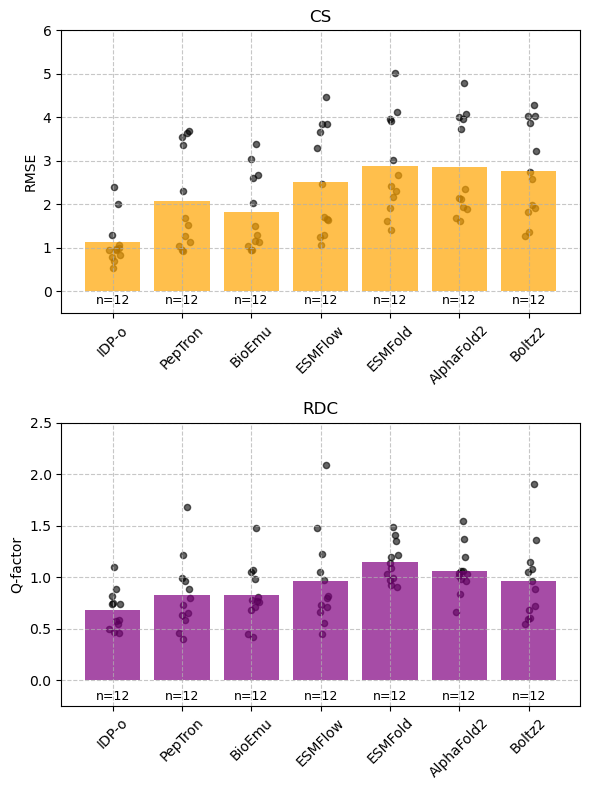

In [16]:


models = [ 
    'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'bioemu', 
    'esmflow', 'esmfold', 'alphafold', 'boltz2'
]
ESS_threshold = 100

# restrict to common proteins
all_protein_sets = [set(corrdict[m].keys()) for m in models]
common_proteins = set.intersection(*all_protein_sets)
print(f"Number of common proteins (after reweighting): {len(common_proteins)}")

statsdict = {}

for model in models:
    qfactors = []
    cs_rmse = []
    for prot in common_proteins:  
        # find optimal posterior
        # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
        min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        
        if corrdict[model][prot]['ESS'][min_idx] >= ESS_threshold:  
            min_idx = min_idx
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold and np.nanmax(corrdict[model][prot]['ESS']) > ESS_threshold:  
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(valid))[0][0]
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold:
            min_idx = np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0]  # first index not nan
        
        qfactors.append(corrdict[model][prot]['Post. Q'][min_idx])
        cs_rmse.append(corrdict[model][prot]['CS RMSE'][min_idx])
    
    statsdict[model] = {
        'Q-factor': qfactors,
        'CS RMSE': cs_rmse
    }

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)

# Replace names for nicer display
df["Model"] = df["Model"].replace(
    {
        "peptron_stable_pdb_idrome_20250812_256000": "PepTron",
        "idp-o": "IDP-o",
        "alphafold": "AlphaFold2",
        "boltz2": "Boltz2",
        "esmflow": "ESMFlow",
        "esmfold": "ESMFold",
        "bioemu": "BioEmu",
        "peptron_stable_pdb_20250809_236800": "PepTron-base"
    }
)

# Define desired display order after renaming
model_order = [
    "IDP-o", "PepTron", "BioEmu", "ESMFlow", "ESMFold", "AlphaFold2", "Boltz2"
]

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharey=False)

for i, metric in enumerate(["CS RMSE", "Q-factor"]):
    df_metric = df[df["Metric"] == metric]
    
    # Compute mean & counts
    summary = df_metric.groupby("Model")["Value"].agg(["mean", "count"]).reset_index()
    
    # Enforce the predefined model order
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)
    summary["Model"] = pd.Categorical(summary["Model"], categories=model_order, ordered=True)
    summary = summary.sort_values("Model")  # keep order consistent
    
    ax = axes[i]
    
    # Bar plot for means
    ax.bar(summary["Model"], summary["mean"],
           color="orange" if metric == "CS RMSE" else "purple", alpha=0.7)
    
    # Scatter plot for all points with jitter
    for j, model in enumerate(summary["Model"]):
        vals = df_metric[df_metric["Model"] == model]["Value"].values
        np.random.seed(0)
        x_jittered = np.random.normal(loc=j, scale=0.05, size=len(vals))
        ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)
    
    # Annotate counts below x-ticks
    for j, row in summary.iterrows():
        ax.text(j, -0.05 if metric == "CS RMSE" else -0.1,
                f"n={row['count']}", ha="center", va="top", fontsize=9)
    
    # Set labels and title
    ax.set_title("CS" if metric == "CS RMSE" else "RDC")
    ax.set_ylabel("RMSE" if metric == "CS RMSE" else "Q-factor")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Set y-limits
    if metric == "CS RMSE":
        ax.set_ylim(-0.5, 6)
    else:
        ax.set_ylim(-0.25, 2.5)

plt.tight_layout()
plt.savefig(output_path + "FINAL_CS_RDC_stats_crosscorr_common_proteins_mean.png", dpi=300)


Number of common proteins (after reweighting): 12


/tmp/ipykernel_2984478/1132377363.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)
/tmp/ipykernel_2984478/1132377363.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)


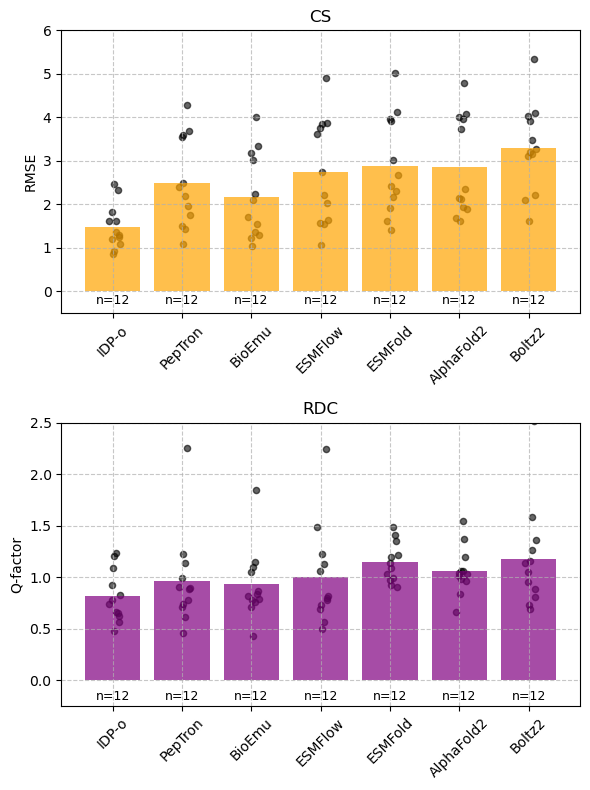

In [18]:


models = [ 
    'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'bioemu', 
    'esmflow', 'esmfold', 'alphafold', 'boltz2'
]
ESS_threshold = 100

# restrict to common proteins
all_protein_sets = [set(corrdict[m].keys()) for m in models]
common_proteins = set.intersection(*all_protein_sets)
print(f"Number of common proteins (after reweighting): {len(common_proteins)}")

statsdict = {}

for model in models:
    qfactors = []
    cs_rmse = []
    for prot in common_proteins:  
        
        
        qfactors.append(corrdict[model][prot]['Prior Q'])
        cs_rmse.append(corrdict[model][prot]['Prior CS RMSE'])
    
    statsdict[model] = {
        'Q-factor': qfactors,
        'CS RMSE': cs_rmse
    }

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)

# Replace names for nicer display
df["Model"] = df["Model"].replace(
    {
        "peptron_stable_pdb_idrome_20250812_256000": "PepTron",
        "idp-o": "IDP-o",
        "alphafold": "AlphaFold2",
        "boltz2": "Boltz2",
        "esmflow": "ESMFlow",
        "esmfold": "ESMFold",
        "bioemu": "BioEmu",
        "peptron_stable_pdb_20250809_236800": "PepTron-base"
    }
)

# Define desired display order after renaming
model_order = [
    "IDP-o", "PepTron", "BioEmu", "ESMFlow", "ESMFold", "AlphaFold2", "Boltz2"
]

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharey=False)

for i, metric in enumerate(["CS RMSE", "Q-factor"]):
    df_metric = df[df["Metric"] == metric]
    
    # Compute mean & counts
    summary = df_metric.groupby("Model")["Value"].agg(["mean", "count"]).reset_index()
    
    # Enforce the predefined model order
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True)
    summary["Model"] = pd.Categorical(summary["Model"], categories=model_order, ordered=True)
    summary = summary.sort_values("Model")  # keep order consistent
    
    ax = axes[i]
    
    # Bar plot for means
    ax.bar(summary["Model"], summary["mean"],
           color="orange" if metric == "CS RMSE" else "purple", alpha=0.7)
    
    # Scatter plot for all points with jitter
    for j, model in enumerate(summary["Model"]):
        vals = df_metric[df_metric["Model"] == model]["Value"].values
        np.random.seed(0)
        x_jittered = np.random.normal(loc=j, scale=0.05, size=len(vals))
        ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)
    
    # Annotate counts below x-ticks
    for j, row in summary.iterrows():
        ax.text(j, -0.05 if metric == "CS RMSE" else -0.1,
                f"n={row['count']}", ha="center", va="top", fontsize=9)
    
    # Set labels and title
    ax.set_title("CS" if metric == "CS RMSE" else "RDC")
    ax.set_ylabel("RMSE" if metric == "CS RMSE" else "Q-factor")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Set y-limits
    if metric == "CS RMSE":
        ax.set_ylim(-0.5, 6)
    else:
        ax.set_ylim(-0.25, 2.5)

plt.tight_layout()
plt.savefig(output_path + "FINAL_CS_RDC_stats_prior_common_proteins_mean.png", dpi=300)


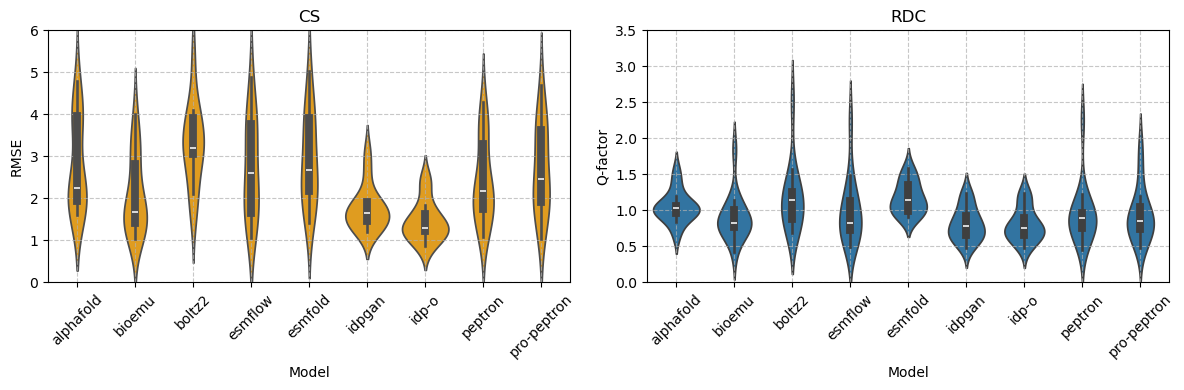

In [12]:
# and same analysis/plot before reweighting (prior)

models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 


statsdict = {}

for model in models:

    proteins = list(corrdict[model].keys())
    qfactors = []
    cs_rmse = []
    for prot in proteins:
        qfactors.append(corrdict[model][prot]['Prior Q'])
        cs_rmse.append(corrdict[model][prot]['Prior CS RMSE'])
    
    statsdict[model] = {}
    statsdict[model]['Q-factor'] = qfactors
    statsdict[model]['CS RMSE'] = cs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Violin plot for CS RMSE
sns.violinplot(data=df[df["Metric"]=="CS RMSE"], 
               x="Model", y="Value", ax=axes[0], inner="box", color="orange")
axes[0].set_title("CS")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, which='major', linestyle='--', alpha=0.7)
axes[0].set_ylim(0,6)

# Violin plot for Q-factor
sns.violinplot(data=df[df["Metric"]=="Q-factor"], 
               x="Model", y="Value", ax=axes[1], inner="box")
axes[1].set_title("RDC")
axes[1].set_ylabel('Q-factor')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, which='major', linestyle='--', alpha=0.7)
axes[1].set_ylim(0,3.5)

plt.tight_layout()
#plt.savefig(output_path+f"final_CS_RDC_stats_prior.png", dpi=300)


/tmp/ipykernel_2984478/2238084229.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
/tmp/ipykernel_2984478/2238084229.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)


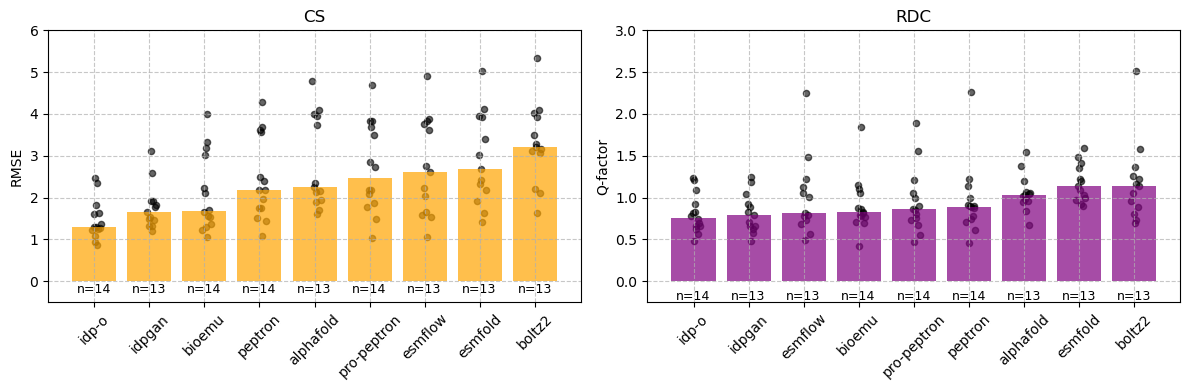

In [20]:
# final bar plots
# using the cross-correlation curves - we find the optimal reweighting theta (where RDC agreement is best to avoid overfitting)
# then we get the statistics for these posterior ensembles

models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800'] 

statsdict = {}

for model in models:

    proteins = list(corrdict[model].keys())
    qfactors = []
    cs_rmse = []
    for prot in proteins:
        qfactors.append(corrdict[model][prot]['Prior Q'])
        cs_rmse.append(corrdict[model][prot]['Prior CS RMSE'])
    
    statsdict[model] = {}
    statsdict[model]['Q-factor'] = qfactors
    statsdict[model]['CS RMSE'] = cs_rmse


# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron",
     "peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, metric in enumerate(["CS RMSE", "Q-factor"]):
    df_metric = df[df["Metric"]==metric]
    
    # Compute medians & counts, sort ascending by median
    summary = df_metric.groupby("Model")["Value"].agg(["median", "count"]).reset_index()
    summary = summary.sort_values("median", ascending=True).reset_index(drop=True)
    
    # Ensure df follows same model order
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
    
    ax = axes[i]
    
    # Bar plot for medians
    ax.bar(summary["Model"], summary["median"], color="orange" if metric=="CS RMSE" else "purple", alpha=0.7)
    
    # Scatter plot for all points with jitter
    for j, model in enumerate(summary["Model"]):
        vals = df_metric[df_metric["Model"]==model]["Value"].values
        np.random.seed(0)
        x_jittered = np.random.normal(loc=j, scale=0.05, size=len(vals))
        ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)
    
    # Annotate counts below x-ticks
    for j, row in summary.iterrows():
        ax.text(j, -0.05 if metric=="CS RMSE" else -0.1, f"n={row['count']}", ha="center", va="top", fontsize=9)
    
    # Set labels and title
    ax.set_title("CS" if metric=="CS RMSE" else "RDC")
    ax.set_ylabel("RMSE" if metric=="CS RMSE" else "Q-factor")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Set y-limits
    if metric=="CS RMSE":
        ax.set_ylim(-0.5, 6)
    else:
        ax.set_ylim(-0.25, 3.)

plt.tight_layout()
#plt.savefig(output_path + "final_CS_RDC_stats_prior.png", dpi=300)


Number of common proteins: 12


/tmp/ipykernel_2984478/4072358792.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
/tmp/ipykernel_2984478/4072358792.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)


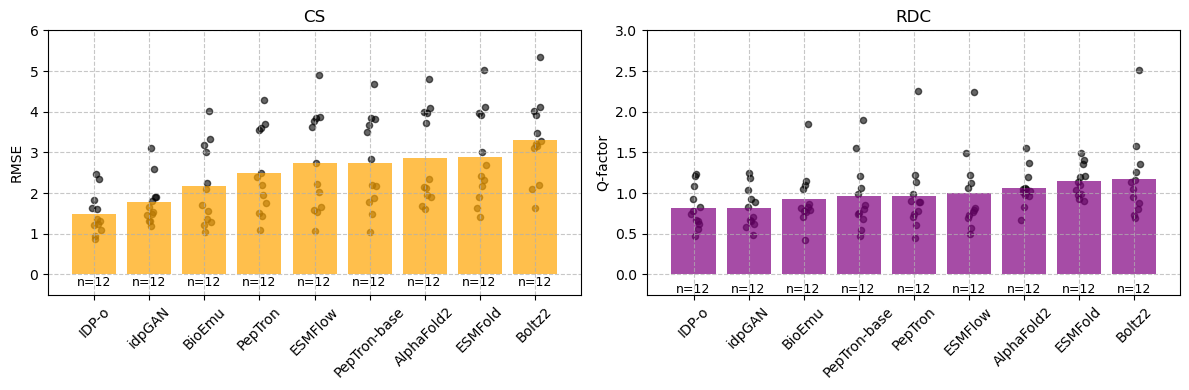

In [21]:
# Find common proteins across all models
all_protein_sets = [set(corrdict[m].keys()) for m in models]
common_proteins = set.intersection(*all_protein_sets)
print(f"Number of common proteins: {len(common_proteins)}")

statsdict = {}

for model in models:
    qfactors = []
    cs_rmse = []
    for prot in common_proteins:  # only use common proteins
        qfactors.append(corrdict[model][prot]['Prior Q'])
        cs_rmse.append(corrdict[model][prot]['Prior CS RMSE'])
    
    statsdict[model] = {
        'Q-factor': qfactors,
        'CS RMSE': cs_rmse
    }

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
# Replace names for nicer display
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "PepTron",
     "peptron_stable_pdb_20250809_236800": "PepTron-base",
     "idp-o": "IDP-o",
     "boltz2": "Boltz2",
     "alphafold": "AlphaFold2",
     "esmfold": "ESMFold",
     "idpgan": "idpGAN",
     "bioemu": "BioEmu",
     "esmflow": "ESMFlow"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, metric in enumerate(["CS RMSE", "Q-factor"]):
    df_metric = df[df["Metric"]==metric]
    
    # Compute medians & counts, sort ascending by mean
    summary = df_metric.groupby("Model")["Value"].agg(["mean", "count"]).reset_index()
    summary = summary.sort_values("mean", ascending=True).reset_index(drop=True)
    
    # Ensure df follows same model order
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)
    
    ax = axes[i]
    
    # Bar plot for means
    ax.bar(summary["Model"], summary["mean"], color="orange" if metric=="CS RMSE" else "purple", alpha=0.7)
    
    # Scatter plot for all points with jitter
    for j, model in enumerate(summary["Model"]):
        vals = df_metric[df_metric["Model"]==model]["Value"].values
        np.random.seed(0)
        x_jittered = np.random.normal(loc=j, scale=0.05, size=len(vals))
        ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)
    
    # Annotate counts below x-ticks
    for j, row in summary.iterrows():
        ax.text(j, -0.05 if metric=="CS RMSE" else -0.1, f"n={row['count']}", ha="center", va="top", fontsize=9)
    
    # Set labels and title
    ax.set_title("CS" if metric=="CS RMSE" else "RDC")
    ax.set_ylabel("RMSE" if metric=="CS RMSE" else "Q-factor")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Set y-limits
    if metric=="CS RMSE":
        ax.set_ylim(-0.5, 6)
    else:
        ax.set_ylim(-0.25, 3.)

plt.tight_layout()
plt.savefig(output_path + "final_ranked_CS_RDC_stats_prior_common_proteins_mean.png", dpi=300)


/tmp/ipykernel_3654997/866605697.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)


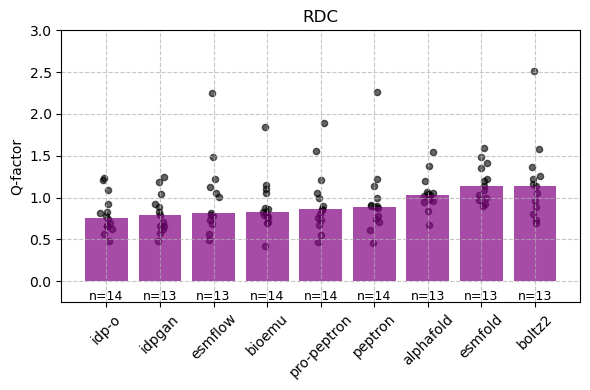

In [ ]:
# all RDCs priors alone


models = [ 'alphafold', 'bioemu',  'boltz2',  'esmflow',  'esmfold',  'idpgan',  'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

statsdict = {}

for model in models:
    proteins = list(corrdict[model].keys())
    qfactors = []
    cs_rmse = []
    for prot in proteins:
        qfactors.append(corrdict[model][prot]['Prior Q'])
        cs_rmse.append(corrdict[model][prot]['Prior CS RMSE'])
    statsdict[model] = {'Q-factor': qfactors, 'CS RMSE': cs_rmse}

# Convert statsdict into dataframe
data = []
for model, vals in statsdict.items():
    for q in vals['Q-factor']:
        data.append({"Model": model, "Metric": "Q-factor", "Value": q})
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "Peptron",
     "peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

# Select metric to plot (Q-factor)
metric = "Q-factor"
df_metric = df[df["Metric"] == metric]

# Compute medians & counts and sort ascending
summary = df_metric.groupby("Model")["Value"].agg(["median", "count"]).reset_index()
summary = summary.sort_values("median", ascending=True).reset_index(drop=True)

# Ensure df follows same model order
df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=summary["Model"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for medians
ax.bar(summary["Model"], summary["median"], color="purple", alpha=0.7)

# Scatter plot of all points with jitter
for i, model in enumerate(summary["Model"]):
    vals = df_metric[df_metric["Model"] == model]["Value"].values
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# Annotate counts below x-ticks
for i, row in summary.iterrows():
    ax.text(i, -0.1, f"n={row['count']}", ha="center", va="top", fontsize=9)

ax.set_title("RDC")
ax.set_ylabel("Q-factor")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-0.25, 3.)

plt.tight_layout()
#plt.savefig(output_path + "all_RDC_prior.png", dpi=300)


/tmp/ipykernel_3654997/2297562471.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


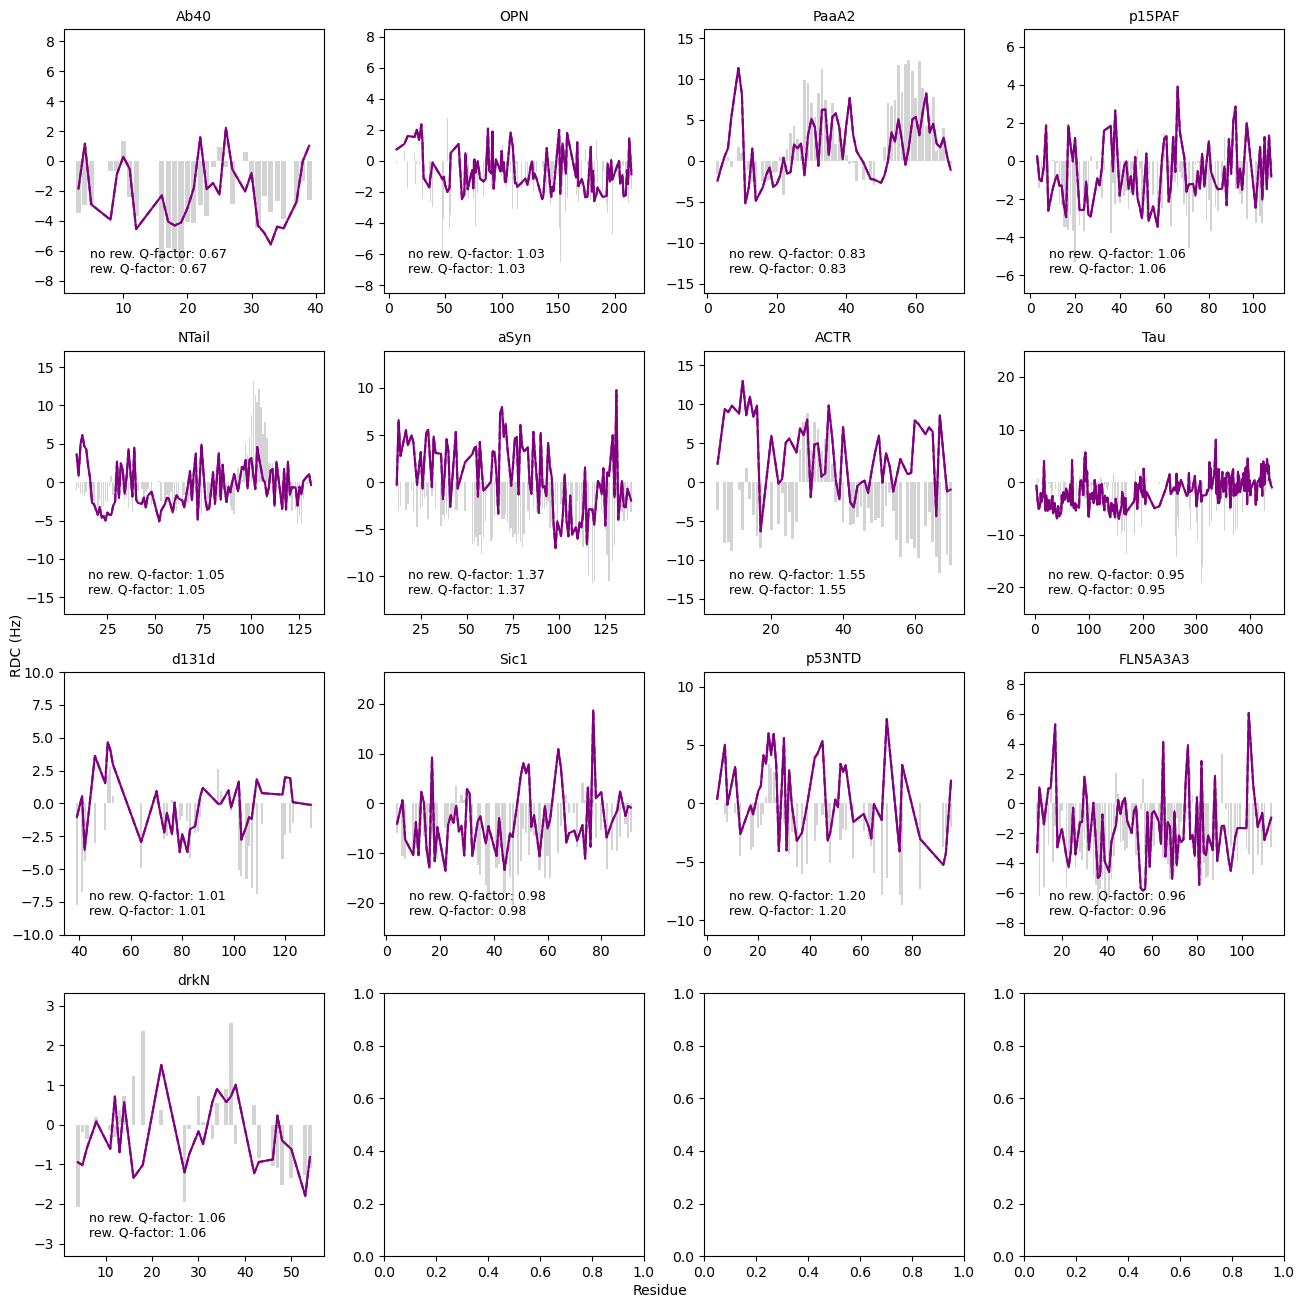

In [25]:
# plot RDCs prior and optimal posterior - final comparison

model = 'alphafold'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/1420046234.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


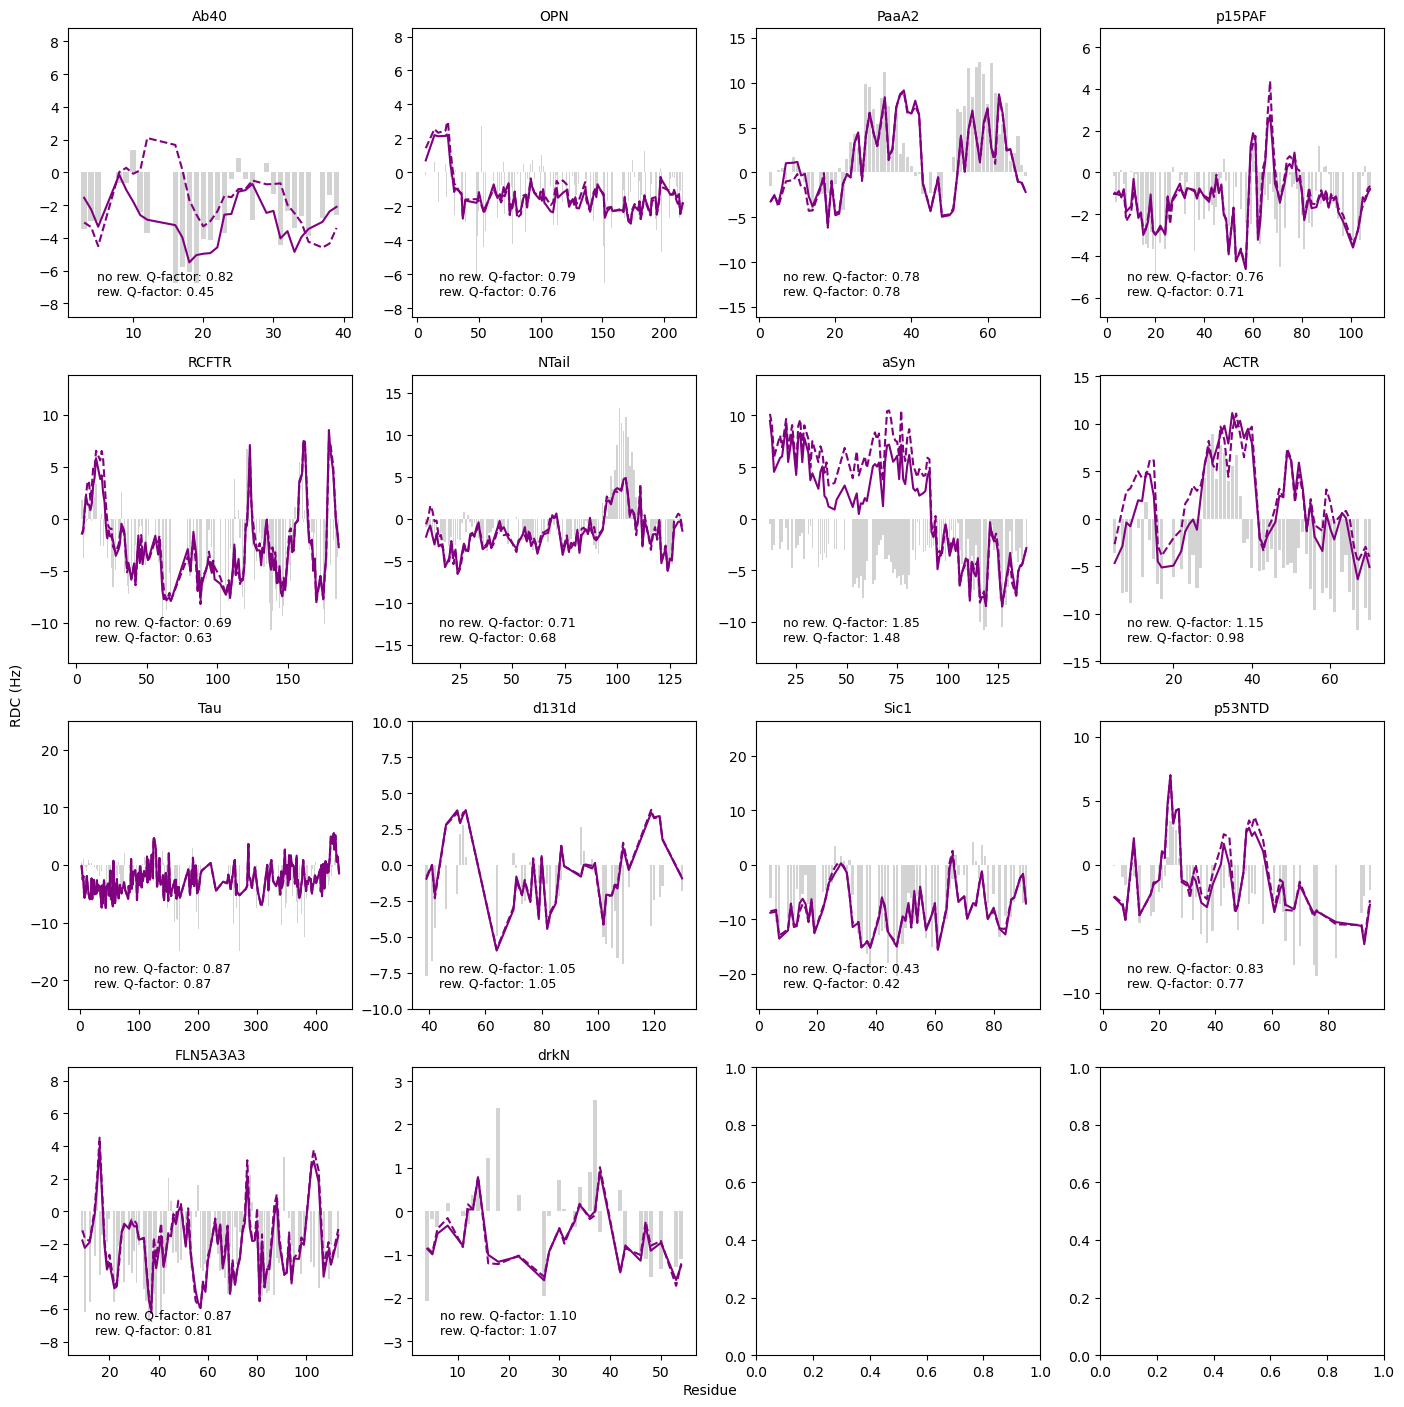

In [26]:
# plot RDCs prior and optimal posterior - final comparison

model = 'bioemu'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/2360993251.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


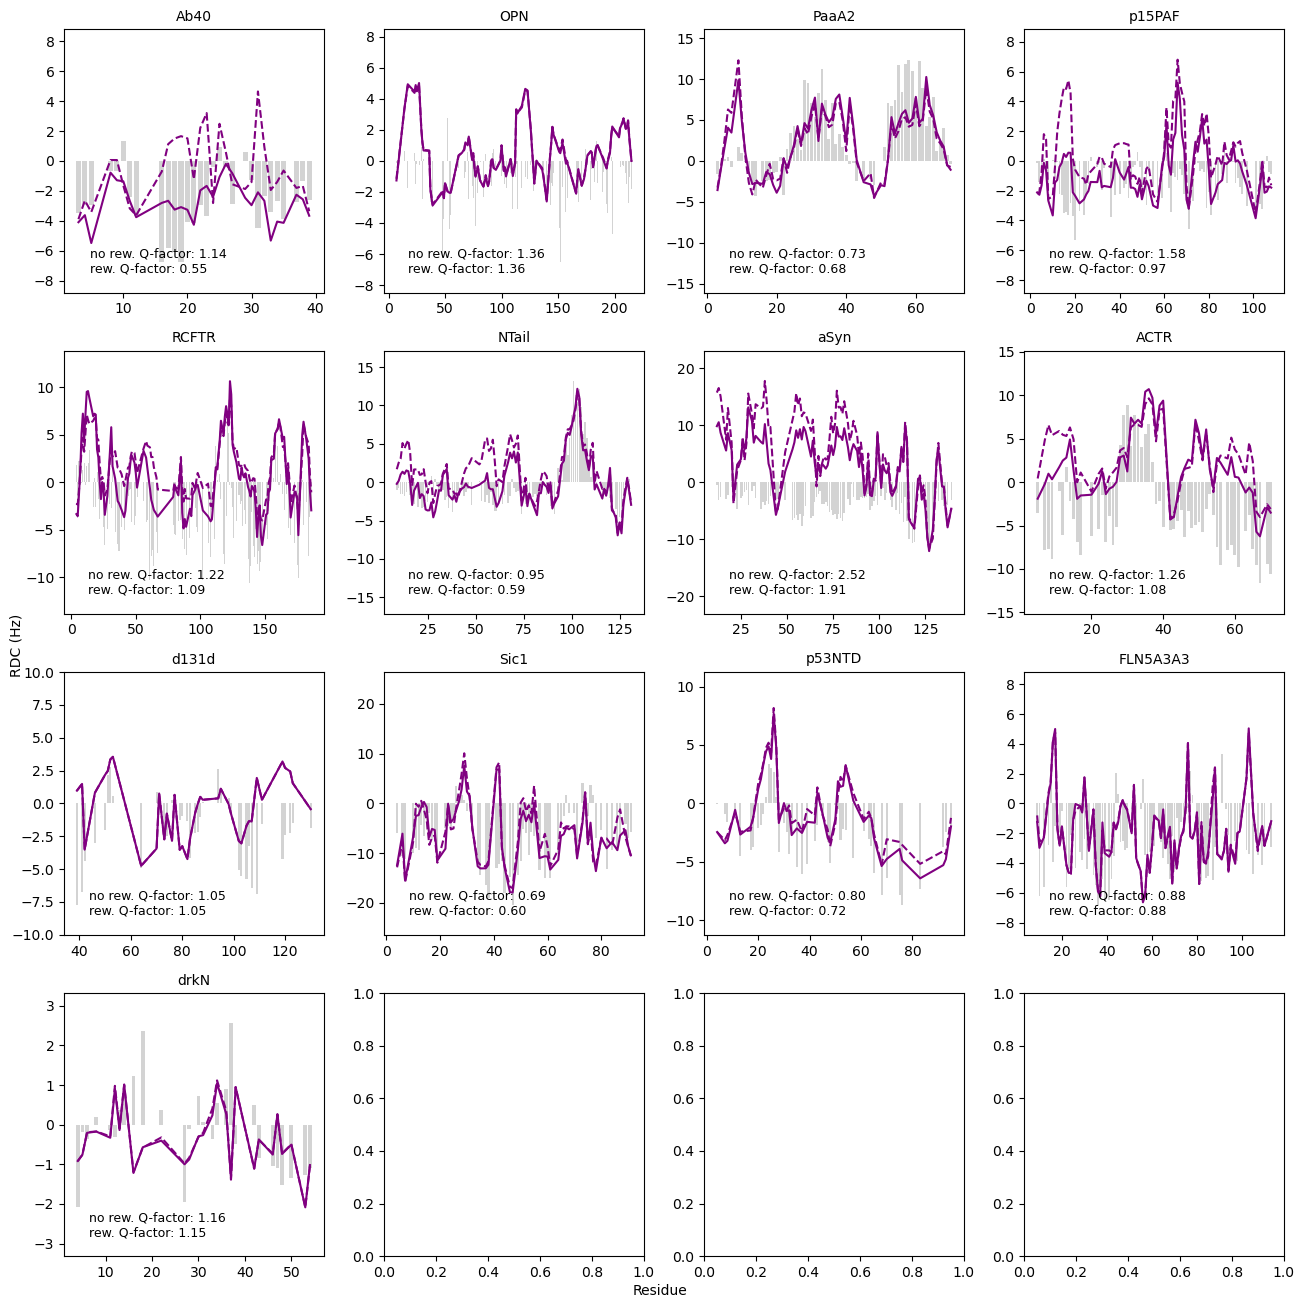

In [27]:
# plot RDCs prior and optimal posterior - final comparison

model = 'boltz2'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/2625339332.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


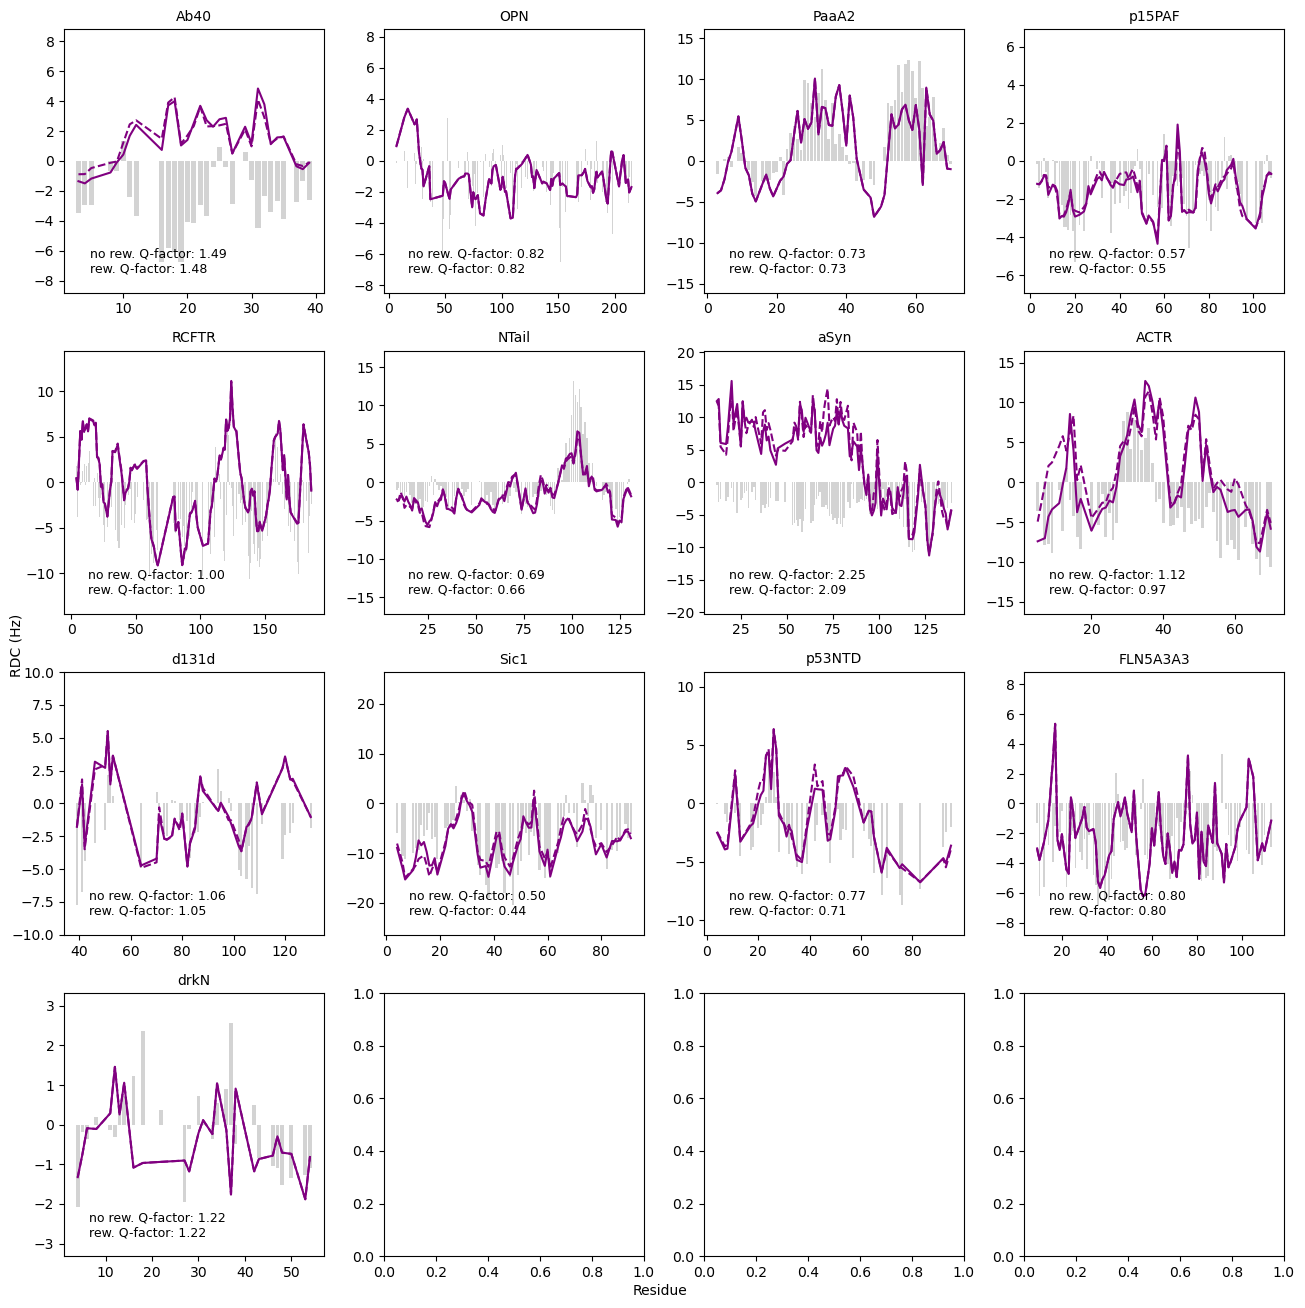

In [28]:
# plot RDCs prior and optimal posterior - final comparison

model = 'esmflow'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/1797618014.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


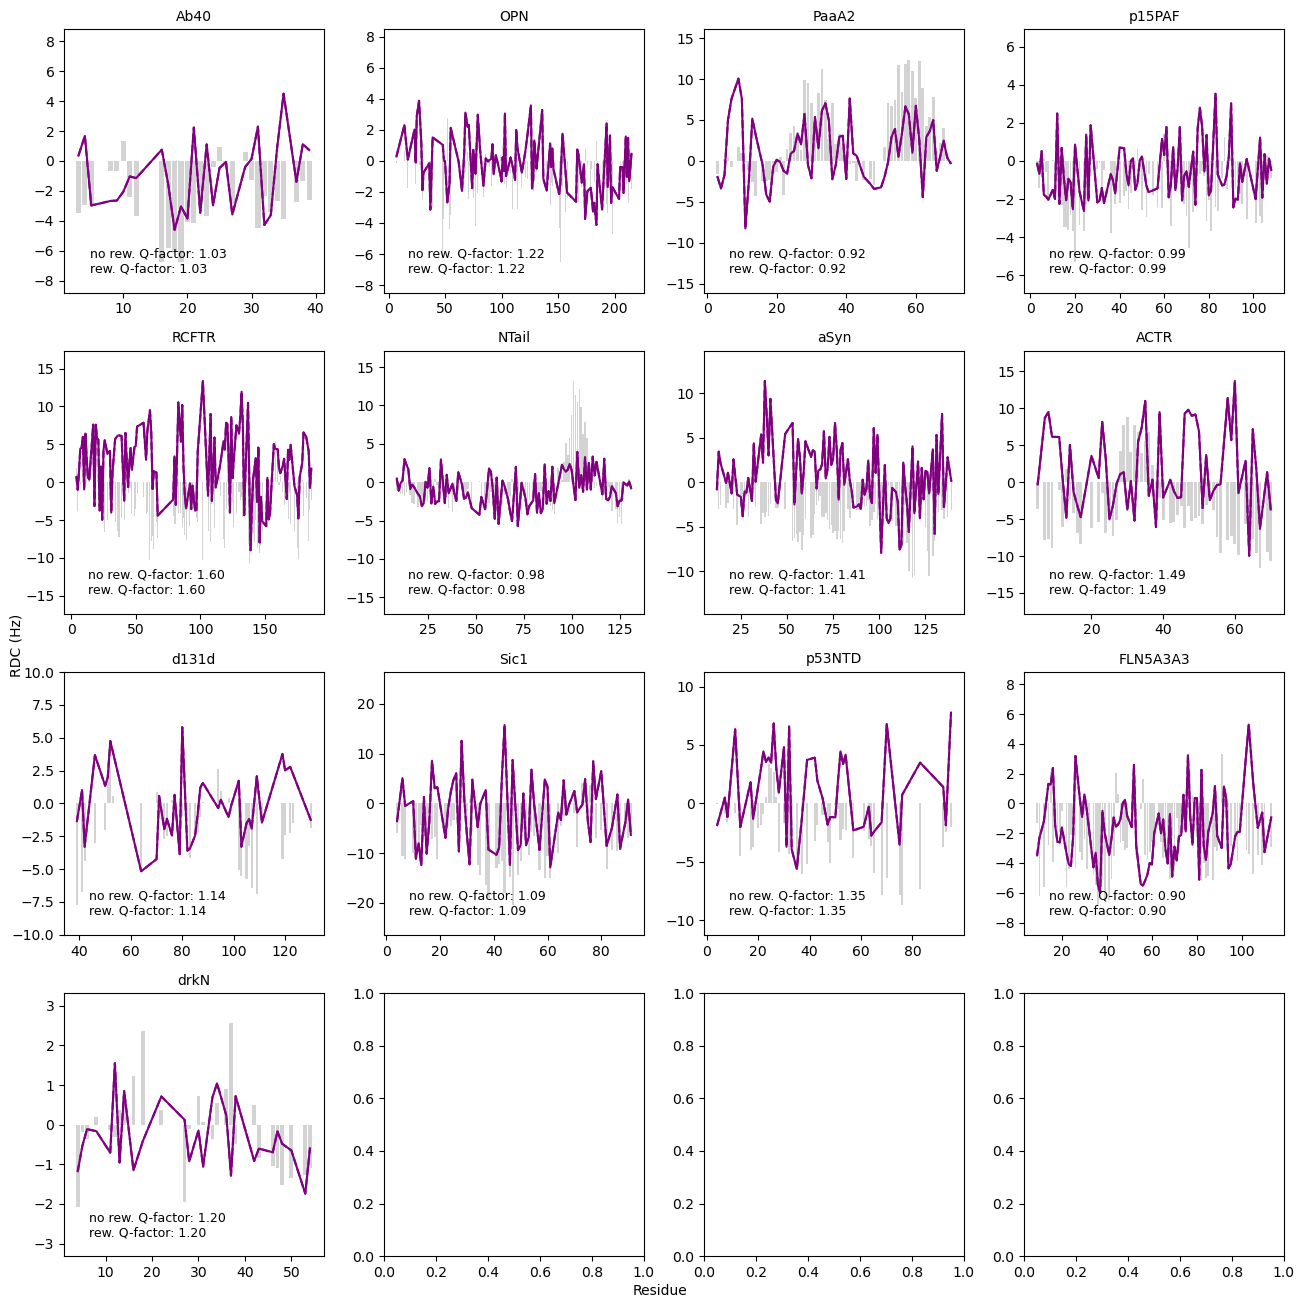

In [29]:
# plot RDCs prior and optimal posterior - final comparison

model = 'esmfold'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/1573461870.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


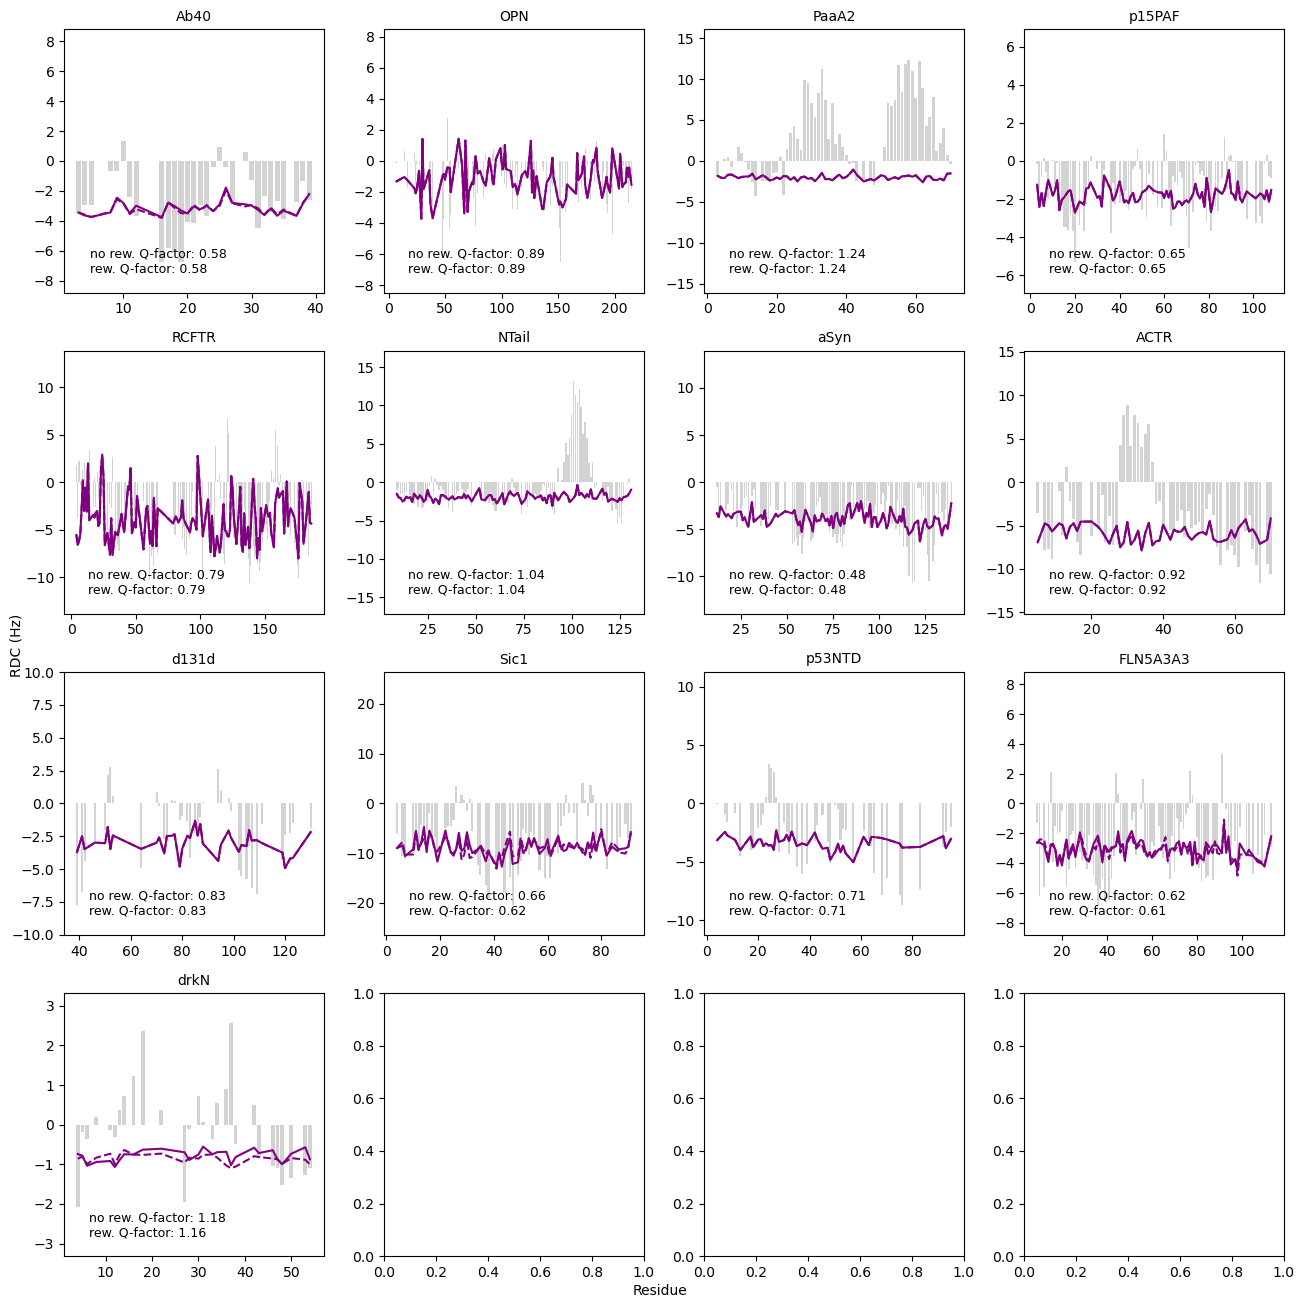

In [30]:
# plot RDCs prior and optimal posterior - final comparison

model = 'idpgan'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/3611910132.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


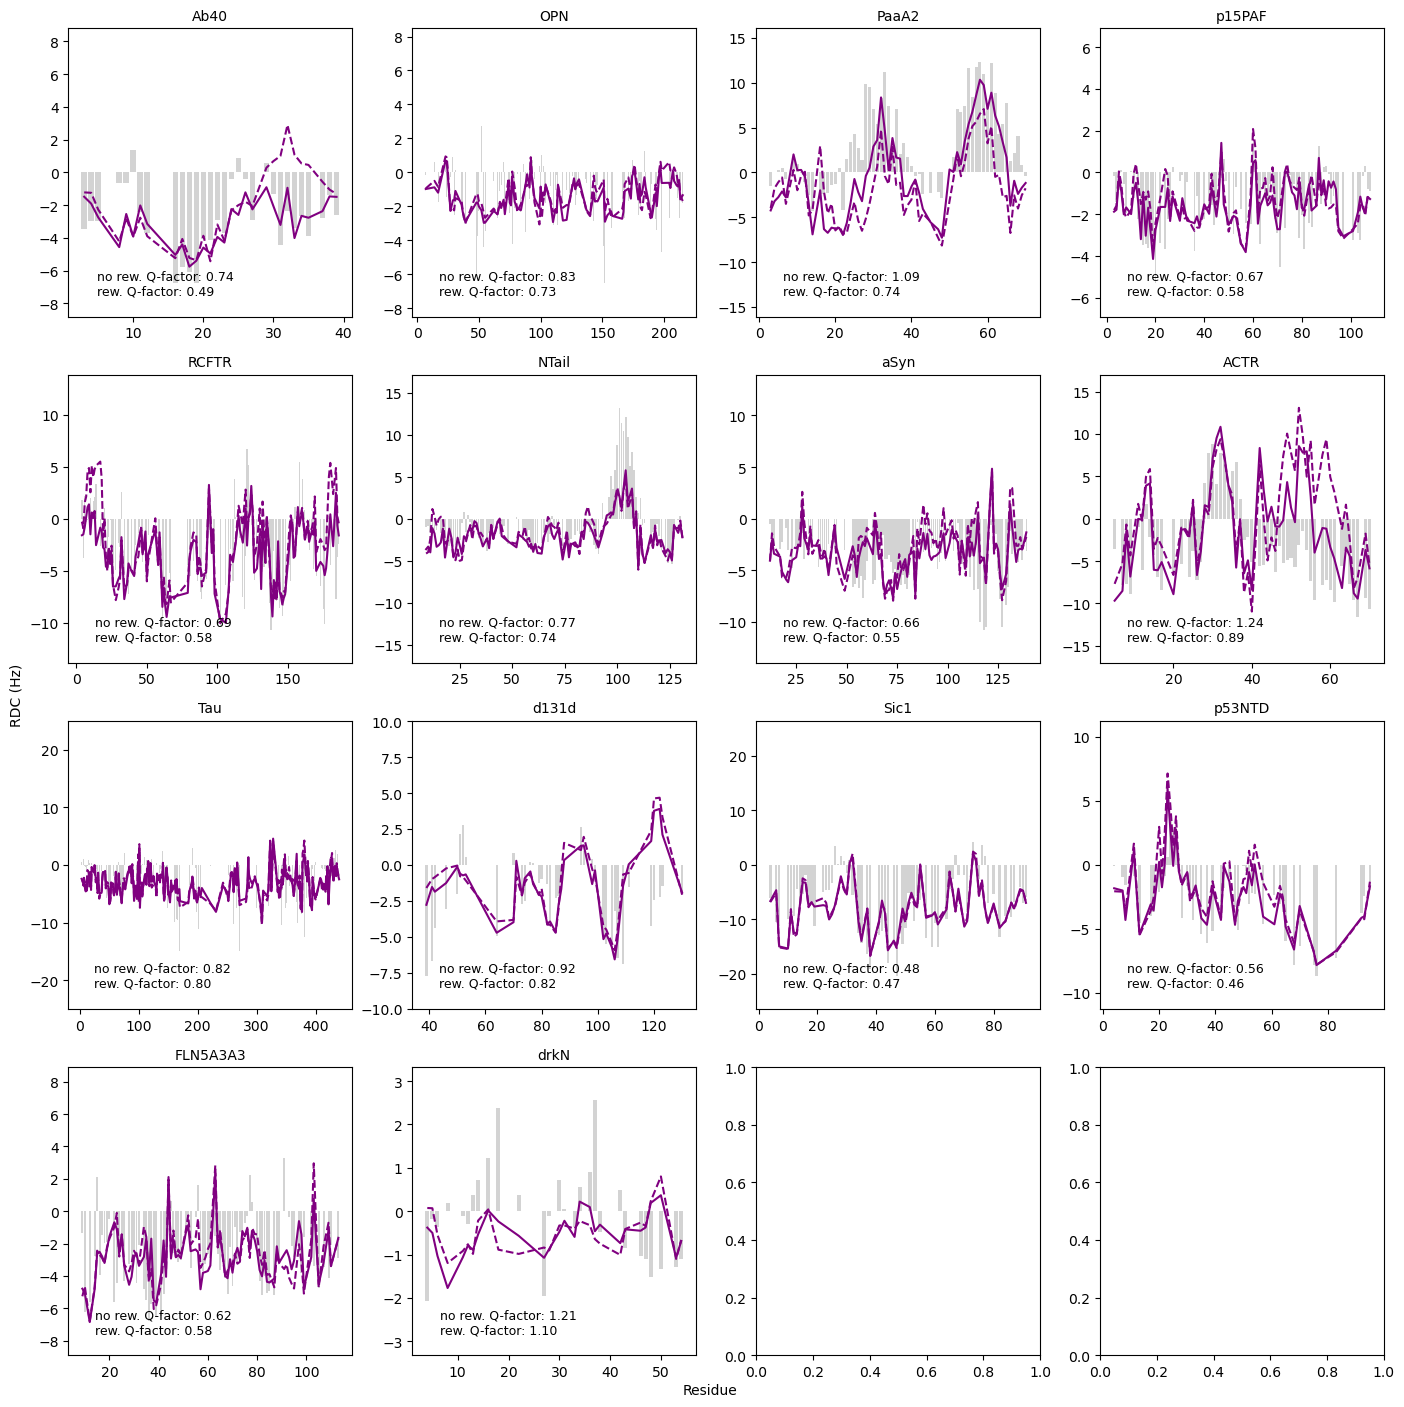

In [31]:
# plot RDCs prior and optimal posterior - final comparison

model = 'idp-o'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/3832966953.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


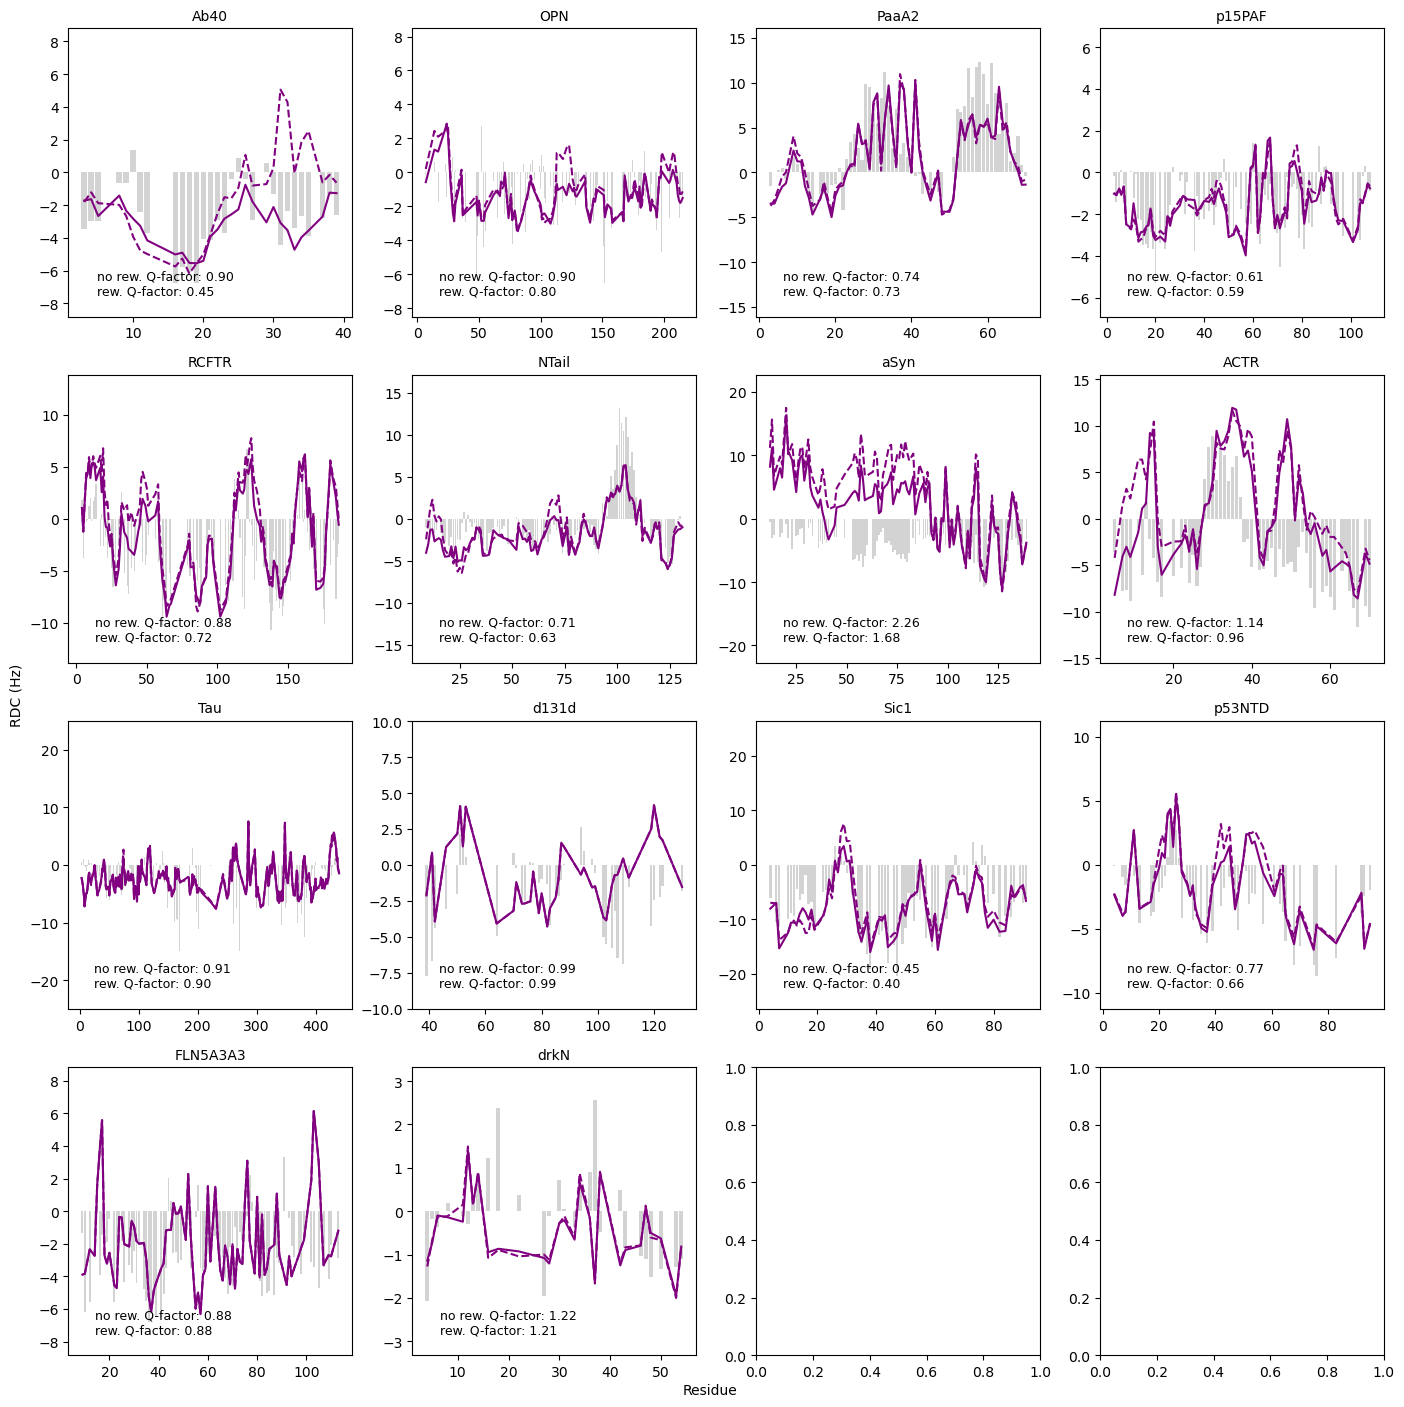

In [32]:
# plot RDCs prior and optimal posterior - final comparison

model = 'peptron_stable_pdb_idrome_20250812_256000'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_3654997/3962510907.py:42: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


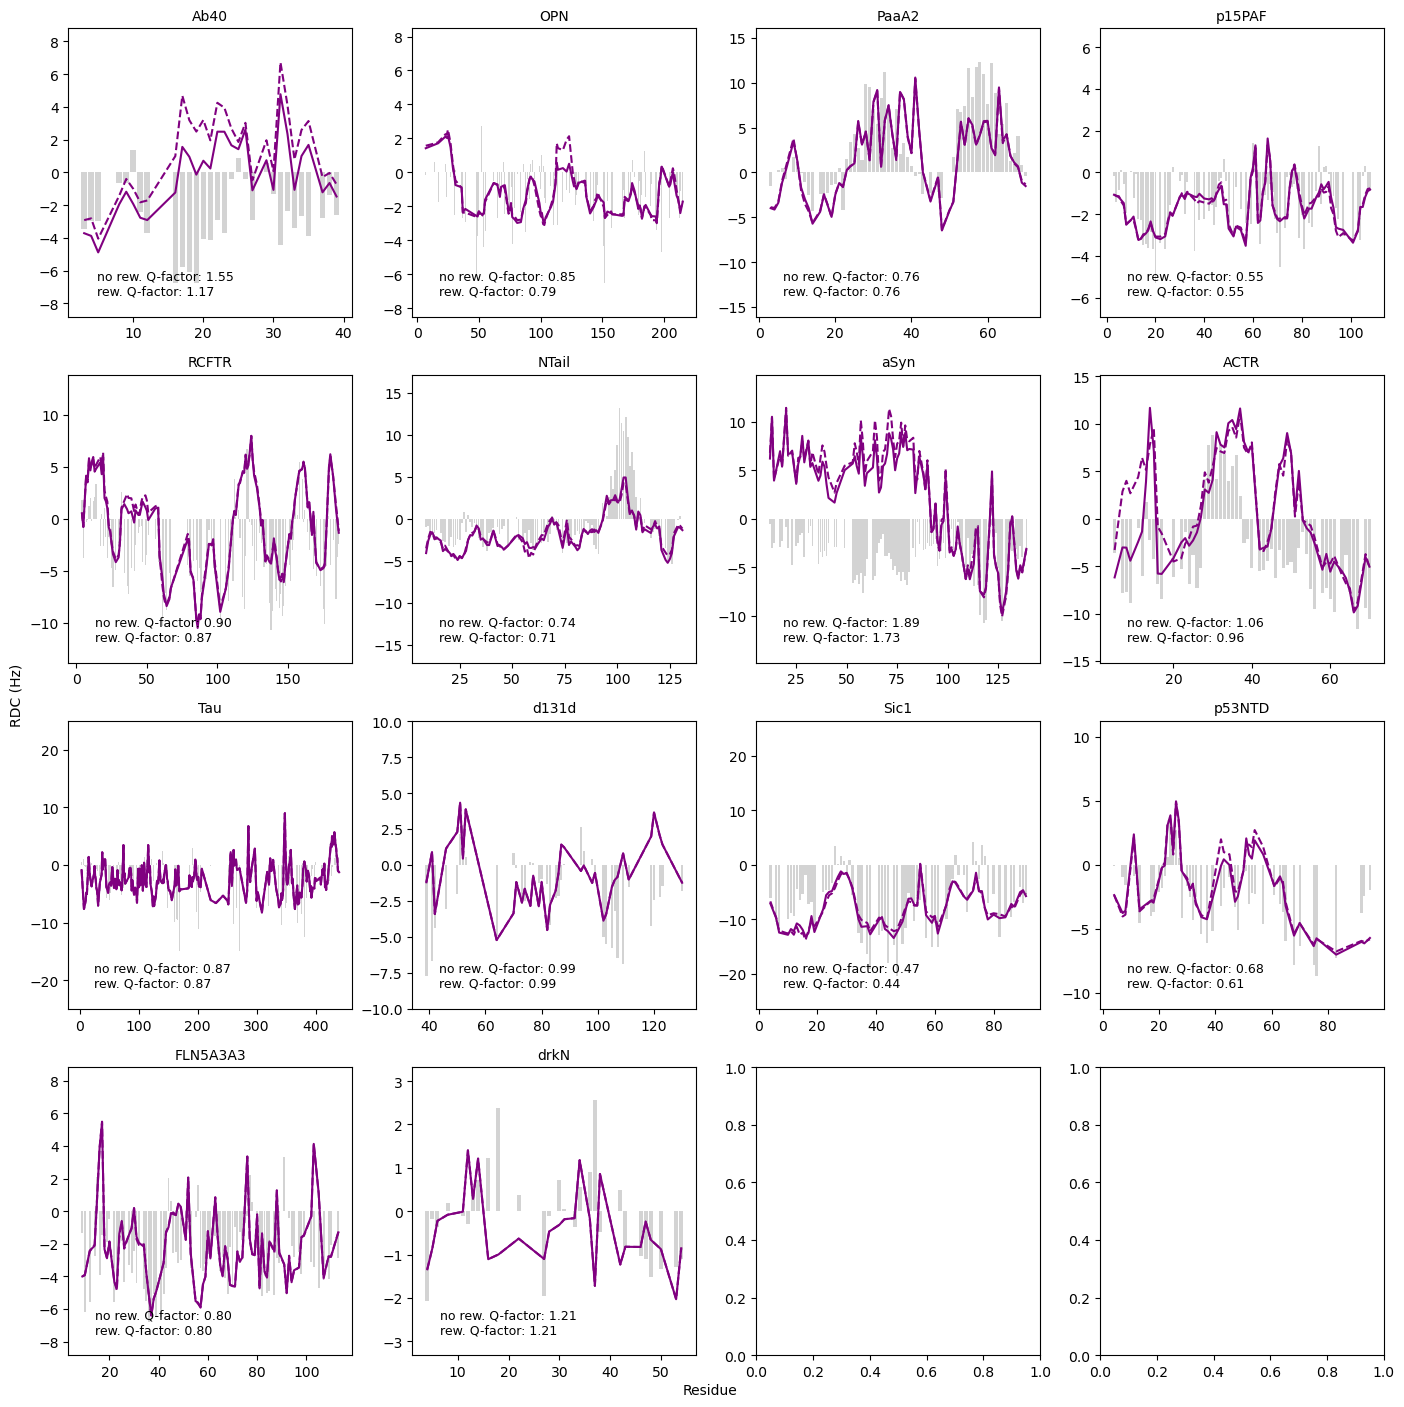

In [33]:
# plot RDCs prior and optimal posterior - final comparison

model = 'peptron_stable_pdb_20250809_236800'
CS_predictor = 'UCBshift'
ESS_threshold=100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

RDCproteins = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(RDCproteins)))
nrows = math.ceil(len(RDCproteins) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(RDCproteins)*1,len(RDCproteins)*1))
axs = axes.ravel() 
for i, prot in enumerate(RDCproteins):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx

    # check calculated test RDCs
    residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    weights = csrew['all_weights'][opt_post_idx]
    weights_nan = weights
    weights = np.nan_to_num(weights, nan=0)

    # experimental data
    expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
    exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

    # remove nan rows
    exp_mask_nan = ~np.isnan(exprdc)
    expres = expres[exp_mask_nan]
    exprdc = exprdc[exp_mask_nan]

    # fasta file and number of total residues
    with open(f'../predictions/fasta/{prot}.fasta','r') as f:
        seq = f.readlines()[1].strip()
    prot_length=len(seq)

    # remove first and last residue from experiment
    if expres[0]==1:
        expres=expres[1:]
        exprdc=exprdc[1:]
    elif expres[-1]==prot_length:
        expres=expres[:-1]
        exprdc=exprdc[:-1]

    # sim indices for which there are experiments
    idxs = []
    for ele in expres:
        idx = list(residues).index(ele)
        idxs.append(idx)
    idxs=np.array(idxs).astype(int)
    residues= np.array(residues)[idxs]
    data = np.array(data)[:,idxs]

    # experimental data
    ax.bar(expres,exprdc, color = 'lightgrey')

    # prior
    scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
    ax.plot(residues, scaled,color='purple', label='no rew.', linestyle='dashed')
    max_magn1 = np.max(np.abs(scaled))

    # posterior
    scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
    ax.plot(residues, scaled, color = 'purple', label='rew.')
    max_magn2 = np.max(np.abs(scaled))
    
    # max magnitude and yscale
    max_magn3 = np.max(np.abs(exprdc))
    max_magn = np.max([max_magn1, max_magn2, max_magn3])
    ax.set_ylim(-max_magn*1.3,max_magn*1.3)

    text_string = str("no rew. Q-factor: {:.2f}\n".format(q_prior)) + str("rew. Q-factor: {:.2f}".format(q))
    range = np.max(residues) - np.min(residues)
    ax.text(np.min(residues)+0.05*range, -max_magn*1.1, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_RDCsalongseq_{model}_exp_vs_calc.png', dpi=200)


/tmp/ipykernel_2984478/1113295250.py:51: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
/tmp/ipykernel_2984478/1113295250.py:51: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
/tmp/ipykernel_2984478/1113295250.py:51: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
/tmp/ipykernel_2984478/1113295250.py:51: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
/tmp/ipykernel_2984478/1113295250.py:51: RuntimeWarning: invalid value encountered in cast
  expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]


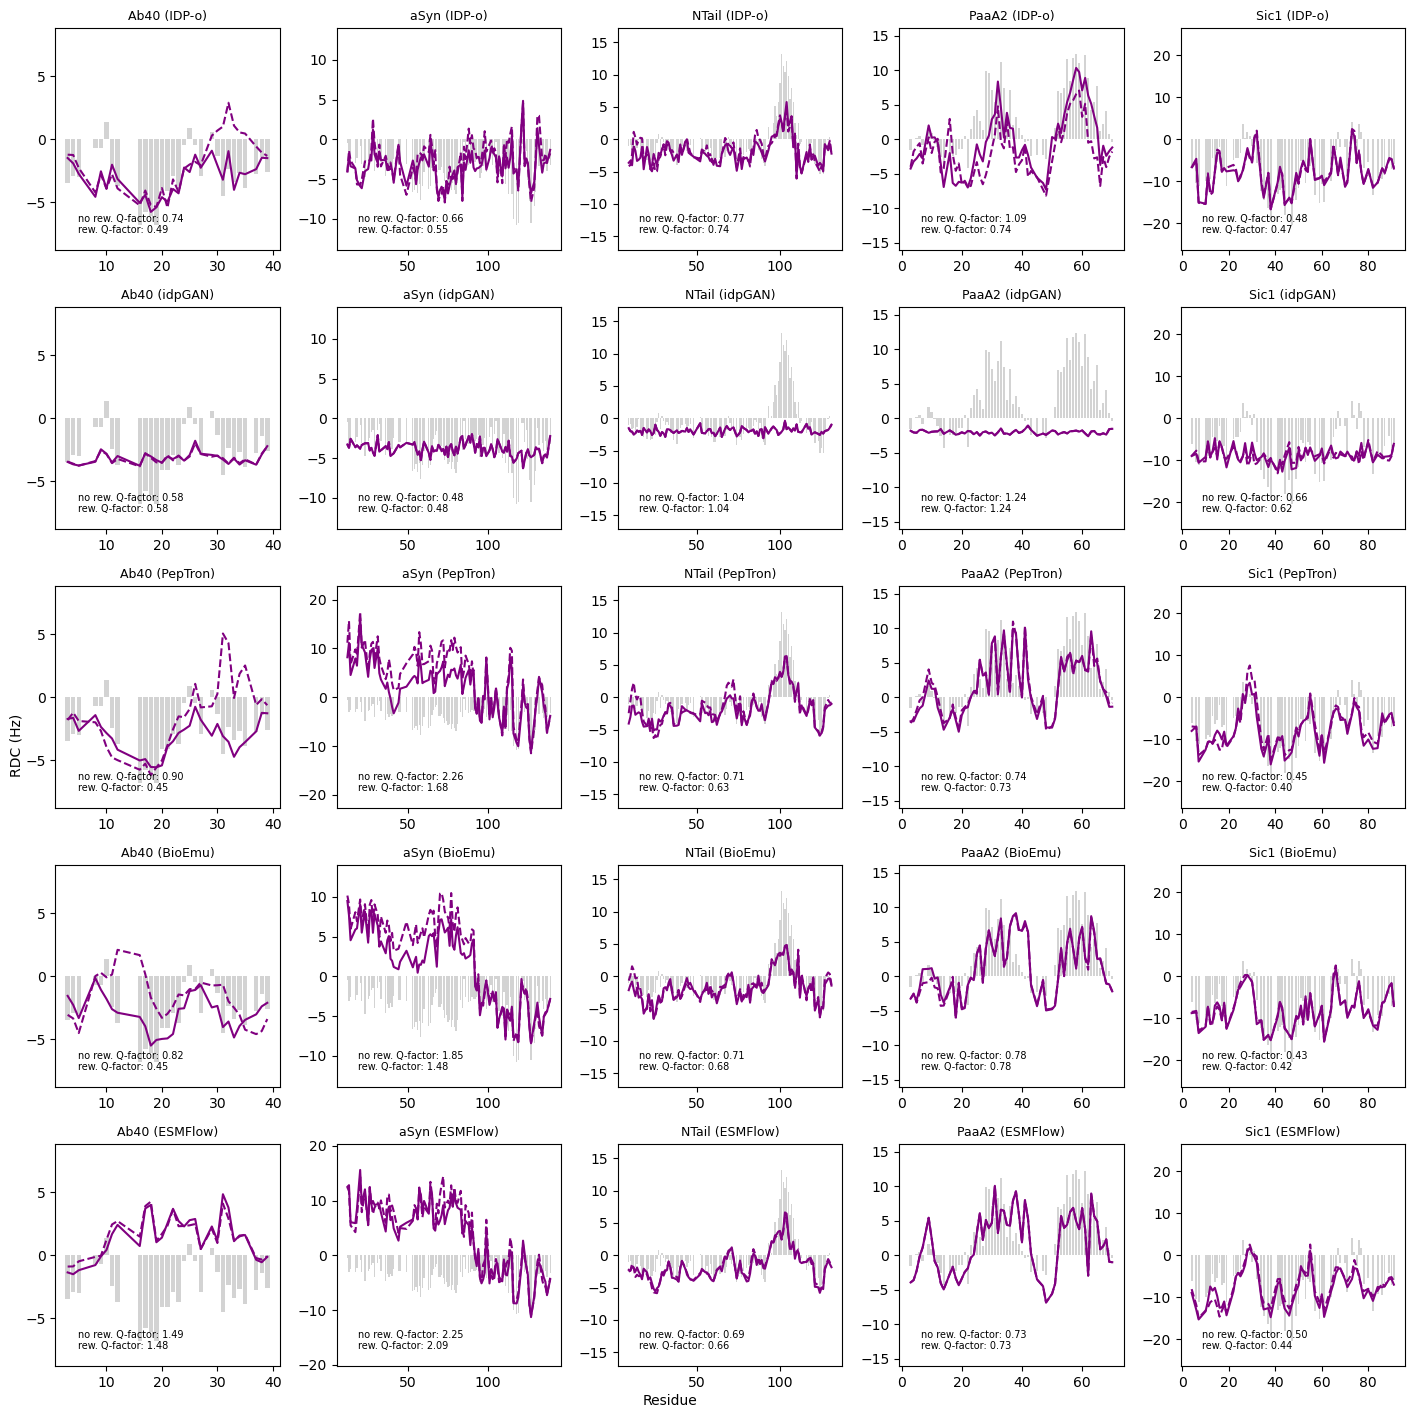

In [26]:
# EXAMPLE PLOT FOR PAPER

# parameters
models = ['idp-o', 'idpgan', 'peptron_stable_pdb_idrome_20250812_256000', 'bioemu', 'esmflow']   # list of models
names = ['IDP-o', 'idpGAN', 'PepTron', 'BioEmu', 'ESMFlow']   # list of models
proteins = ['Ab40', 'aSyn', 'NTail', 'PaaA2', 'Sic1']       # list of proteins
CS_predictor = 'UCBshift'
ESS_threshold = 100

# load CS cross correlation dictionary
corrdict = np.load(output_path+'RDC_CSrew_corr_analysis_dict.npy', allow_pickle=True).item()

# prepare figure
nrows = len(models)
ncols = len(proteins)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

# if only one row or col, ensure axes is 2D
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

for r, model in enumerate(models):
    for c, prot in enumerate(proteins):
        ax = axes[r, c]
        ax.set_title(f"{prot} ({names[r]})", fontsize=9)

        # ---- find optimal posterior ----
        min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        if corrdict[model][prot]['ESS'][min_idx] >= ESS_threshold:
            min_idx = min_idx
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold and np.nanmax(corrdict[model][prot]['ESS']) > ESS_threshold:
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(valid))[0][0]
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold:
            min_idx = np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0]
        opt_post_idx = min_idx

        # ---- load RDC data ----
        residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{prot}/RDC.csv')
        csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy', allow_pickle=True).item()
        weights = csrew['all_weights'][opt_post_idx]
        weights_nan = weights
        weights = np.nan_to_num(weights, nan=0)

        # experimental data
        expres = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat').astype(int)[:,0]
        exprdc = np.loadtxt(f'../EXP_DATA/{prot}/RDC_HN.dat')[:,1]

        # remove nan rows
        exp_mask_nan = ~np.isnan(exprdc)
        expres = expres[exp_mask_nan]
        exprdc = exprdc[exp_mask_nan]

        # fasta file and number of total residues
        with open(f'../predictions/fasta/{prot}.fasta','r') as f:
            seq = f.readlines()[1].strip()
        prot_length = len(seq)

        # remove first/last residue if present
        if expres[0] == 1:
            expres = expres[1:]
            exprdc = exprdc[1:]
        elif expres[-1] == prot_length:
            expres = expres[:-1]
            exprdc = exprdc[:-1]

        # sim indices for which there are experiments
        idxs = [list(residues).index(ele) for ele in expres]
        idxs = np.array(idxs).astype(int)
        residues = np.array(residues)[idxs]
        data = np.array(data)[:, idxs]

        # ---- plotting ----
        ax.bar(expres, exprdc, color='lightgrey')

        # prior
        scaled, s, q_prior, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights_nan, prior='True', scale_matching='True')
        ax.plot(residues, scaled, color='purple', linestyle='dashed', label='no rew.')
        max_magn1 = np.max(np.abs(scaled))

        # posterior
        scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
        ax.plot(residues, scaled, color='purple', label='rew.')
        max_magn2 = np.max(np.abs(scaled))

        # max magnitude and yscale
        max_magn3 = np.max(np.abs(exprdc))
        max_magn = np.max([max_magn1, max_magn2, max_magn3])
        ax.set_ylim(-max_magn*1.3, max_magn*1.3)

        text_string = f"no rew. Q-factor: {q_prior:.2f}\nrew. Q-factor: {q:.2f}"
        rng = np.max(residues) - np.min(residues)
        ax.text(np.min(residues)+0.05*rng, -max_magn*1.1, text_string, fontsize=7)

# Master x and y labels
fig.text(0.5, 0.06, 'Residue', ha='center', fontsize=10)
fig.text(0.06, 0.5, f'RDC (Hz)', va='center', rotation='vertical', fontsize=10)


plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.savefig(output_path+'EXAMPLE_RDCs_models_vs_proteins.png', dpi=200)



0.6815701488239386
0.7816269072637002
0.9204219664032592
0.7156746062218983
0.7776056673914508
0.8929714504919484


<BarContainer object of 63 artists>

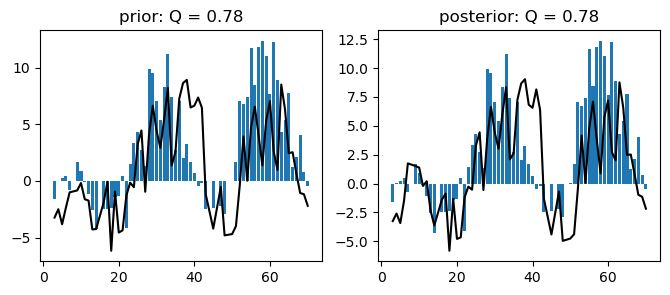

In [50]:
# check individual proteins


model = 'bioemu'
protein = 'PaaA2'

# check calculated test RDCs
residues, data = read_calc_RDCs(f'../protonated_predictions/{model}/{protein}/RDC.csv')
csrew = np.load(f'../protonated_predictions/{model}/{protein}/CSrew_UCBshift.npy',allow_pickle=True).item()
weights = csrew['weights']
weights_nan = weights
weights = np.nan_to_num(weights, nan=0)

# experimental data
expres = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat').astype(int)[:,0]
exprdc = np.loadtxt(f'../EXP_DATA/{protein}/RDC_HN.dat')[:,1]

# remove nan rows
exp_mask_nan = ~np.isnan(exprdc)
expres = expres[exp_mask_nan]
exprdc = exprdc[exp_mask_nan]

# fasta file and number of total residues
with open(f'../predictions/fasta/{protein}.fasta','r') as f:
    seq = f.readlines()[1].strip()
prot_length=len(seq)

# remove first and last residue from experiment
if expres[0]==1:
    expres=expres[1:]
    exprdc=exprdc[1:]
elif expres[-1]==prot_length:
    expres=expres[:-1]
    exprdc=exprdc[:-1]

# sim indices for which there are experiments
idxs = []
for ele in expres:
    idx = list(residues).index(ele)
    idxs.append(idx)
idxs=np.array(idxs).astype(int)
residues= np.array(residues)[idxs]
data = np.array(data)[:,idxs]

plt.figure(figsize = (8,3))

plt.subplot(1,2,1)
scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights=weights_nan, prior='True', scale_matching='True')
print(s)
print(q)
print(q_nonscaled)
plt.title('prior: Q = {:.2f}'.format(q))
plt.plot(residues, scaled,color='black')
#plt.plot(residues, np.average(data,axis=0),color='green')
plt.bar(expres,exprdc)

plt.subplot(1,2,2)
scaled, s, q, q_nonscaled = scale_rdcs_to_minimize_q(data, exprdc, weights, prior='False', scale_matching='True')
print(s)
print(q)
print(q_nonscaled)
plt.title('posterior: Q = {:.2f}'.format(q))
plt.plot(residues, scaled,color='black')
#plt.plot(residues, np.average(data,weights=weights,axis=0),color='green')
plt.bar(expres,exprdc)

(0.0, 1.0)

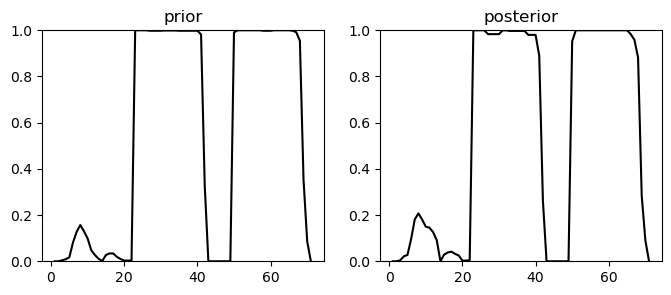

In [51]:
# check secondary structure
u = md.load(f"../processed_predictions/{model}/{protein}.xtc", top = f"../processed_predictions/{model}/{protein}.pdb")
dssp = md.compute_dssp(u,simplified=True)
residues = np.arange(1,dssp.shape[1]+1)

plt.figure(figsize = (8,3))

plt.subplot(1,2,1)

plt.title('prior')
plt.plot(residues, np.average((dssp=='H')*1,axis=0),color='black')
plt.ylim(0,1)

plt.subplot(1,2,2)
plt.title('posterior')
plt.plot(residues, np.average((dssp=='H')*1,weights=weights, axis=0),color='black')
plt.ylim(0,1)